# <font color='darkblue'>Setup</font> 

Todo:

Add in the threshold method to compare

## <font color='orange'>Packages</font> 

In [31]:
# Packages -----------------------------------------------#

# Data Analysis
import xarray as xr
import numpy as np
import pandas as pd
from scipy import stats
from scipy.ndimage import gaussian_filter
import datetime as dt
from scipy.interpolate import griddata

# Plotting
import cartopy.crs as ccrs
from cartopy.feature import LAND
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

# Timing Processes and Progress
import time
from tqdm import tqdm

# make sure the figures plot inline rather than at the end
%matplotlib inline

## <font color='orange'>Functions</font> 

In [32]:
# display progress for long loops -----------------------------------------------------#
def progress_bar(itr,total):
    from time import sleep
    import sys
    sys.stdout.write('\r')
    
    if itr > 0:
        prev = np.round((itr-1)/total*100,2)
    else:
        prev = 0
    
    curr = np.round(itr/total*100,2)
    if (curr != prev):
        # the exact output you're looking for:
#         sys.stdout.write('[%-2s] %d%%' % ('='*int(curr), curr))
        sys.stdout.write('%d%%' % (curr))
        sys.stdout.flush()

# filtering a 2D matrix ---------------------------------------------------------------#
def gaus_filter_nan(img,sigma = 1):
    # import required packages
    from astropy.convolution import convolve
    from astropy.convolution import Gaussian2DKernel
    
    # create a kernal with std = 1
    kernel = Gaussian2DKernel(x_stddev=1)
    
    #convolve that with the 2d matrix
    img_conv = convolve(img, kernel)

    # set original nan points back to nans
    img_conv[np.isnan(img)] = np.nan

    return img_conv

# put coastlines on map and set xy limits ---------------------------------------------#
def add_land(ax,bounds= [35,120,-20,30]):
    from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
    ax.add_feature(cfeature.LAND,color='gray',zorder = 1)
    ax.background_patch.set_facecolor('k')
    ax.coastlines(resolution='110m',zorder = 2)
    g = ax.gridlines(draw_labels=True,alpha=0)
    g.xlabels_top = False
    g.ylabels_right = False
    g.xlabel_style = {'size': 15}
    g.ylabel_style = {'size': 15}
    g.xformatter = LONGITUDE_FORMATTER
    g.yformatter = LATITUDE_FORMATTER
    ax.axes.axis('tight')
    ax.set_extent(bounds, crs=ccrs.PlateCarree())
    return None 

# mask coastlines ---------------------------------------------------------------------#
def mask_coast(c_lon,c_lat,bounds):
    data=xr.open_dataset('/tigress/GEOCLIM/LRGROUP/shared_data/pco2_flux_coastal_Roobaert/mask_ocean.nc')
    mask_coast=np.array(data.mask_coastal2).astype(int).T
    lat=np.array(data.latitude)
    lon=np.array(data.longitude)

    mask_lon=np.logical_and(lon>bounds[0],lon<bounds[1])
    mask_lat=np.logical_and(lat>bounds[2],lat<bounds[3])

    lon=lon[mask_lon]
    lat=lat[mask_lat]

    mask_coast=mask_coast[mask_lat]
    mask_coast=mask_coast[:,mask_lon]

    lonlon,latlat=np.meshgrid(lon,lat)

    # what are these for? I should probably fix it
    lon_dot=np.array([70,70])
    lat_dot=np.array([10,19.5])

    mask=[]
    for lo,la in zip(c_lon,c_lat):
        if len(lon[lon<=lo])>0 and len(lat[lat>=la])>0 and len(lon[lon>=lo])>0 and len(lat[lat<=la])>0:
            lon_lim=[lon[lon<=lo][-1],lon[lon>=lo][0]]
            lat_lim=[lat[lat<=la][-1],lat[lat>=la][0]]
            mask_lon=np.logical_or(lon==lon_lim[0],lon==lon_lim[1])
            mask_lat=np.logical_or(lat==lat_lim[0],lat==lat_lim[1])
            mask_tmp=mask_coast[mask_lat]
            mask_tmp=mask_tmp[:,mask_lon]
            mask.append(np.mean(mask_tmp)>0)
        else:
            mask.append(False)
    mask=np.array(mask)
    return mask

# create pcolormesh lat/lon vals ------------------------------------------------------#
def pcolor_xy(x,y):
    # extend longitude by 2
    x_extend = np.zeros(x.size+2)
    # fill in internal values
    x_extend[1:-1] = x # fill up with original values
    # fill in extra endpoints
    x_extend[0] = x[0]-np.diff(x)[0]
    x_extend[-1] = x[-1]+np.diff(x)[-1]
    # calculate the midpoints
    x_pcolormesh_midpoints = x_extend[:-1]+0.5*(np.diff(x_extend))

    # extend latitude by 2
    y_extend = np.zeros(y.size+2)
    # fill in internal values
    y_extend[1:-1] = y
    # fill in extra endpoints
    y_extend[0] = y[0]-np.diff(y)[0]
    y_extend[-1] = y[-1]+np.diff(y)[-1]
    # calculate the midpoints
    y_pcolormesh_midpoints = y_extend[:-1]+0.5*(np.diff(y_extend))
    
    return x_pcolormesh_midpoints,y_pcolormesh_midpoints
    
# binning for one variable ------------------------------------------------------------#
def latlonbin(invar,lat,lon,bounds,binwidth):
    import numpy as np
    
    # create a pandas dataframe
    df = pd.DataFrame(dict(
            invar = np.array(invar),
            lat= np.array(lat),
            lon= np.array(lon),
        ))

    # create 1 degree bins
    latedges = np.arange(bounds[2]-(binwidth/2),bounds[3]+(binwidth/2),binwidth)
    lat_inds = list(range(len(latedges)-1))

    lonedges = np.arange(bounds[0]-(binwidth/2),bounds[1]+(binwidth/2),binwidth)
    lon_inds = list(range(len(lonedges)-1))

    latbins = latedges[1:]-(binwidth/2)
    lonbins = lonedges[1:]-(binwidth/2)

    df['latedges'] = pd.cut(lat, latedges)
    df['lonedges'] = pd.cut(lon, lonedges)
    df['latbins_ind'] = pd.cut(lat, latedges,labels = lat_inds)
    df['lonbins_ind'] = pd.cut(lon, lonedges,labels = lon_inds)
    df['lat_lon_indx']=df.groupby(['latbins_ind', 'lonbins_ind']).ngroup()
    grouped = df.groupby(['latbins_ind', 'lonbins_ind'])

    invar_BINNED = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray)
    invar_BINNED[:] = np.nan

    invar_binned_ave = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray)
    invar_binned_ave[:] = np.nan
    
    invar_bincounts = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray)
    invar_bincounts[:] = np.nan


    #extract the data for each group
    for name, group in grouped:
        i = np.array(group.latbins_ind)
        j = np.array(group.lonbins_ind)

        invar_BINNED[i[0],j[0]] = group.invar

        invar_binned_ave[i[0],j[0]] = np.nanmean(group.invar)   
        
        invar_bincounts[i[0],j[0]] = len(group.invar[np.isfinite(group.invar)]) 

    return np.array(invar_binned_ave,dtype = float),np.array(invar_bincounts,dtype = float),latbins,lonbins

# month of min OCD plus other vars  -----------------------------------------------------#
def latlonbin_min_OCD(OCD,TCD,doxy_upper,doxy_lower,lat,lon,bounds,binwidth):
    import numpy as np
    
    # create a pandas dataframe
    df = pd.DataFrame(dict(
            doxy_upper = np.array(doxy_upper),
            doxy_lower = np.array(doxy_lower),
            OCD = np.array(OCD),
            TCD = np.array(TCD),
            lat= np.array(lat),
            lon= np.array(lon),
            month = np.array(OCD.time.dt.month)
        ))
    
    # create 1 degree bins
    latedges = np.arange(bounds[2]-(binwidth/2),bounds[3]+(binwidth/2),binwidth)
    lat_inds = list(range(len(latedges)-1))

    lonedges = np.arange(bounds[0]-(binwidth/2),bounds[1]+(binwidth/2),binwidth)
    lon_inds = list(range(len(lonedges)-1))

    latbins = latedges[1:]-(binwidth/2)
    lonbins = lonedges[1:]-(binwidth/2)

    df['latedges'] = pd.cut(lat, latedges)
    df['lonedges'] = pd.cut(lon, lonedges)
    df['latbins_ind'] = pd.cut(lat, latedges,labels = lat_inds)
    df['lonbins_ind'] = pd.cut(lon, lonedges,labels = lon_inds)
    df['lat_lon_indx']=df.groupby(['latbins_ind', 'lonbins_ind']).ngroup()
    grouped = df.groupby(['latbins_ind', 'lonbins_ind'])

    min_OCD = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray) * np.nan
    min_OCD_month = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray) * np.nan
    min_OCD_TCD = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray) * np.nan
    min_OCD_doxy_upper = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray) * np.nan
    min_OCD_doxy_lower = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray) * np.nan

    #extract the data for each group
    for name, group in grouped:
        i = np.array(group.latbins_ind)
        j = np.array(group.lonbins_ind)
        gpmonth = np.array(group.month)
        gpOCD = np.array(group.OCD)
        gpTCD = np.array(group.TCD)
        gpdoxy_upper = np.array(group.doxy_upper)
        gpdoxy_lower = np.array(group.doxy_lower)

        # find month of minimum OCD
        if ~np.isnan(np.nanmin(gpOCD)):
            
            min_OCD[i[0],j[0]] = np.nanmin(gpOCD)
            
            ind = np.nanargmin(gpOCD)
            
            min_OCD_month[i[0],j[0]] = gpmonth[ind]
            min_OCD_TCD[i[0],j[0]] = gpTCD[ind]       
            min_OCD_doxy_upper[i[0],j[0]] = gpdoxy_upper[ind]
            min_OCD_doxy_lower[i[0],j[0]] = gpdoxy_lower[ind]

    return(np.array(min_OCD,dtype = float),np.array(min_OCD_month,dtype = float),
           np.array(min_OCD_TCD,dtype = float),
           np.array(min_OCD_doxy_upper,dtype = float),
           np.array(min_OCD_doxy_lower,dtype = float),
           latbins,lonbins)

# month of min doxy plus other vars  -----------------------------------------------------#
def latlonbin_min_doxy(doxy,OCD,TCD,lat,lon,bounds,binwidth):
    import numpy as np
    
    if len(doxy.shape) > 1:
        doxy = np.nanmin(doxy,1)
    
    # create a pandas dataframe
    df = pd.DataFrame(dict(
            doxy = np.array(doxy),
            OCD = np.array(OCD),
            TCD = np.array(TCD),
            lat= np.array(lat),
            lon= np.array(lon),
            month = np.array(OCD.time.dt.month)
        ))
    
    # create 1 degree bins
    latedges = np.arange(bounds[2]-(binwidth/2),bounds[3]+(binwidth/2),binwidth)
    lat_inds = list(range(len(latedges)-1))

    lonedges = np.arange(bounds[0]-(binwidth/2),bounds[1]+(binwidth/2),binwidth)
    lon_inds = list(range(len(lonedges)-1))

    latbins = latedges[1:]-(binwidth/2)
    lonbins = lonedges[1:]-(binwidth/2)

    df['latedges'] = pd.cut(lat, latedges)
    df['lonedges'] = pd.cut(lon, lonedges)
    df['latbins_ind'] = pd.cut(lat, latedges,labels = lat_inds)
    df['lonbins_ind'] = pd.cut(lon, lonedges,labels = lon_inds)
    df['lat_lon_indx']=df.groupby(['latbins_ind', 'lonbins_ind']).ngroup()
    grouped = df.groupby(['latbins_ind', 'lonbins_ind'])

    min_doxy = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray) * np.nan
    min_doxy_month = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray) * np.nan
    min_doxy_TCD = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray) * np.nan
    min_doxy_OCD = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray) * np.nan

    #extract the data for each group
    for name, group in grouped:
        i = np.array(group.latbins_ind)
        j = np.array(group.lonbins_ind)
        gpmonth = np.array(group.month)
        gpOCD = np.array(group.OCD)
        gpTCD = np.array(group.TCD)
        gpdoxy = np.array(group.doxy)

        # find month of minimum OCD
        if ~np.isnan(np.nanmin(gpdoxy)):
            
            min_doxy[i[0],j[0]] = np.nanmin(gpdoxy)
            
            ind = np.nanargmin(gpdoxy)
            
            min_doxy_month[i[0],j[0]] = gpmonth[ind]
            min_doxy_TCD[i[0],j[0]] = gpTCD[ind]  
            min_doxy_OCD[i[0],j[0]] = gpOCD[ind]    

    return(np.array(min_doxy,dtype = float),np.array(min_doxy_month,dtype = float),
           np.array(min_doxy_TCD,dtype = float),
           np.array(min_doxy_OCD,dtype = float),
           latbins,lonbins)

## <font color='orange'>Read Data</font> 

### <font color='lightblue'>Merged ARGO WOD GOSHIP</font> 

In [33]:
# get merged data from tigress
path_AWG = '../data/Merged/'
infn_AWG = 'Profiles_temp_psal_doxy_processed.nc'

ds_AWG = xr.open_dataset(path_AWG + infn_AWG)

# find average for upper 0-50 dbar
doxy_upper = np.array(ds_AWG.doxy[:,ds_AWG.pres<50])
doxy_upper_mean = np.nanmean(doxy_upper,1)

# find average for lower 50-200 dbar 
doxy_lower = np.array(ds_AWG.doxy[:,(ds_AWG.pres>50) & (ds_AWG.pres<200)])
doxy_lower_mean = np.nanmean(doxy_lower,1)

# find average for lower 0-200 dbar 
doxy_TC = np.array(ds_AWG.doxy[:,ds_AWG.pres<200])
doxy_TC_mean = np.nanmean(doxy_TC,1)

ds_AWG['doxy_upper'] = xr.DataArray(doxy_upper,dims = ['time','upper_pres'],coords =[ds_AWG.time,ds_AWG.pres[ds_AWG.pres<50]])
ds_AWG['doxy_upper_mean'] = xr.DataArray(doxy_upper_mean,dims = ['time'],coords =[ds_AWG.time])

ds_AWG['doxy_lower'] = xr.DataArray(doxy_lower,dims = ['time','lower_pres'],coords =[ds_AWG.time,ds_AWG.pres[(ds_AWG.pres>50) & (ds_AWG.pres<200)]])
ds_AWG['doxy_lower_mean'] = xr.DataArray(doxy_lower_mean,dims = ['time'],coords =[ds_AWG.time])

ds_AWG['doxy_TC'] = xr.DataArray(doxy_TC,dims = ['time','TC_pres'],coords =[ds_AWG.time,ds_AWG.pres[ds_AWG.pres<200]])
ds_AWG['doxy_TC_mean'] = xr.DataArray(doxy_TC_mean,dims = ['time'],coords =[ds_AWG.time])

ds_AWG

/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice


<xarray.Dataset>
Dimensions:          (TC_pres: 40, lower_pres: 29, pres: 201, time: 306118, upper_pres: 10)
Coordinates:
    prof             (time) int32 ...
  * time             (time) datetime64[ns] 1827-10-30 1836-05-15 ... 2020-02-07
  * pres             (pres) int32 0 5 10 15 20 25 ... 975 980 985 990 995 1000
  * upper_pres       (upper_pres) int32 0 5 10 15 20 25 30 35 40 45
  * lower_pres       (lower_pres) int32 55 60 65 70 75 ... 175 180 185 190 195
  * TC_pres          (TC_pres) int32 0 5 10 15 20 25 ... 170 175 180 185 190 195
Data variables:
    temp             (time, pres) float32 ...
    psal             (time, pres) float32 ...
    doxy             (time, pres) float32 ...
    lat              (time) float32 ...
    lon              (time) float32 ...
    type             (time) int32 ...
    doxy_upper       (time, upper_pres) float32 nan nan nan nan ... nan nan nan
    doxy_upper_mean  (time) float32 nan nan nan nan nan ... nan nan nan nan nan
    doxy_lower       

Text(0, 0.5, 'min doxy')

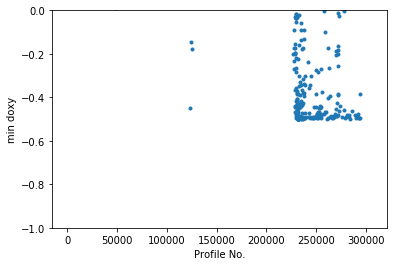

In [34]:
plt.plot(ds_AWG.doxy.min(dim = 'pres'),'.')
plt.ylim([-1,0])
plt.xlabel('Profile No.')
plt.ylabel('min doxy')

# eventually remove these - first do Mathieu's stuff and WOA to confirm things match before changing it

### <font color='lightblue'>WOA</font> 

In [35]:
# WOA
path_WOA="../data/WOA/"
infn_WOA = 'woa_awg_processed.nc'

ds_WOA = xr.open_dataset(path_WOA + infn_WOA)
ds_WOA

<xarray.Dataset>
Dimensions:  (month: 306118, pres: 201)
Coordinates:
  * month    (month) int64 10 5 12 2 5 2 2 3 3 3 2 2 ... 2 2 2 2 2 2 2 2 2 2 2 2
  * pres     (pres) float64 0.0 5.0 10.0 15.0 20.0 ... 985.0 990.0 995.0 1e+03
Data variables:
    temp     (month, pres) float64 ...
    psal     (month, pres) float64 ...
    doxy     (month, pres) float64 ...
    lon      (month) float64 ...
    lat      (month) float64 ...

# <font color='darkblue'>Profiles and Profile Anomalies</font> 

In [36]:
# initialize new dataset to store results
ds_CD = xr.Dataset(coords={'time': ds_AWG.time})
ds_CD['lon'] = ds_AWG.lon
ds_CD['lat'] = ds_AWG.lat

#add to dataset - note no pressure difference since the average is the current one
ds_CD['temp_AWG'] = ds_AWG.temp
ds_CD['doxy_AWG'] = ds_AWG.doxy

ds_CD['temp_WOA'] = ds_WOA.temp
ds_CD['doxy_WOA'] = ds_WOA.doxy

ds_CD['temp_anom'] = ds_AWG.temp - np.array(ds_WOA.temp)
ds_CD['doxy_anom'] = ds_AWG.doxy - np.array(ds_WOA.doxy)

# <font color='darkblue'>Find TCD and OCD</font> 

In [37]:
# Find centered dT/dp and dO/dp
temp_grad_AWG = ds_CD.temp_AWG.differentiate("pres")/ds_CD.pres.differentiate("pres")
doxy_grad_AWG = ds_CD.doxy_AWG.differentiate("pres")/ds_CD.pres.differentiate("pres")

temp_grad_WOA = ds_CD.temp_WOA.differentiate("pres")/ds_CD.pres.differentiate("pres")
doxy_grad_WOA = ds_CD.doxy_WOA.differentiate("pres")/ds_CD.pres.differentiate("pres")

pres_grad = ds_AWG.pres

#add to dataset - note no pressure difference since the average is the current one
ds_CD['temp_grad_AWG'] = xr.DataArray(temp_grad_AWG,dims = ['time','pres_grad'],coords =[ds_AWG.time,pres_grad])
ds_CD['doxy_grad_AWG'] = xr.DataArray(doxy_grad_AWG,dims = ['time','pres_grad'],coords =[ds_AWG.time,pres_grad])

ds_CD['temp_grad_WOA'] = xr.DataArray(temp_grad_WOA,dims = ['month','pres_grad'],coords =[ds_WOA.month,pres_grad])
ds_CD['doxy_grad_WOA'] = xr.DataArray(doxy_grad_WOA,dims = ['month','pres_grad'],coords =[ds_WOA.month,pres_grad])

# lightly smooth profiles
temp_grad_sm_10_AWG = ds_CD.temp_grad_AWG.rolling(pres_grad=13, center=True, min_periods = 3).mean()
doxy_grad_sm_10_AWG = ds_CD.doxy_grad_AWG.rolling(pres_grad=7, center=True, min_periods = 3).mean()

temp_grad_sm_10_WOA = ds_CD.temp_grad_WOA.rolling(pres_grad=13, center=True, min_periods = 3).mean()
doxy_grad_sm_10_WOA = ds_CD.doxy_grad_WOA.rolling(pres_grad=7, center=True, min_periods = 3).mean()

#add to dataset
ds_CD['temp_grad_sm_10_AWG'] = xr.DataArray(temp_grad_sm_10_AWG,dims = ['time','pres_grad'],coords =[ds_AWG.time,pres_grad])
ds_CD['doxy_grad_sm_10_AWG'] = xr.DataArray(doxy_grad_sm_10_AWG,dims = ['time','pres_grad'],coords =[ds_AWG.time,pres_grad])
ds_CD['temp_grad_sm_10_WOA'] = xr.DataArray(temp_grad_sm_10_WOA,dims = ['month','pres_grad'],coords =[ds_WOA.month,pres_grad])
ds_CD['doxy_grad_sm_10_WOA'] = xr.DataArray(doxy_grad_sm_10_WOA,dims = ['month','pres_grad'],coords =[ds_WOA.month,pres_grad])

#mask the nans in the arrays so that the functions work as expected 
temp_grad_AWG = np.ma.masked_array(ds_CD.temp_grad_AWG, np.isnan(ds_CD.temp_grad_AWG))
doxy_grad_AWG = np.ma.masked_array(ds_CD.doxy_grad_AWG, np.isnan(ds_CD.doxy_grad_AWG))

temp_grad_sm_10_AWG = np.ma.masked_array(ds_CD.temp_grad_sm_10_AWG, np.isnan(ds_CD.temp_grad_sm_10_AWG))
doxy_grad_sm_10_AWG = np.ma.masked_array(ds_CD.doxy_grad_sm_10_AWG, np.isnan(ds_CD.doxy_grad_sm_10_AWG))

temp_grad_WOA = np.ma.masked_array(ds_CD.temp_grad_WOA, np.isnan(ds_CD.temp_grad_WOA))
doxy_grad_WOA = np.ma.masked_array(ds_CD.doxy_grad_WOA, np.isnan(ds_CD.doxy_grad_WOA))

temp_grad_sm_10_WOA = np.ma.masked_array(ds_CD.temp_grad_sm_10_WOA, np.isnan(ds_CD.temp_grad_sm_10_WOA))
doxy_grad_sm_10_WOA = np.ma.masked_array(ds_CD.doxy_grad_sm_10_WOA, np.isnan(ds_CD.doxy_grad_sm_10_WOA))

# find data above 400dbars
upper_temp_grad_AWG = temp_grad_AWG[:,pres_grad<500]
upper_doxy_grad_AWG = doxy_grad_AWG[:,pres_grad<500]

upper_temp_grad_sm_10_AWG = temp_grad_sm_10_AWG[:,pres_grad<500]
upper_doxy_grad_sm_10_AWG = doxy_grad_sm_10_AWG[:,pres_grad<500]

upper_temp_grad_WOA = temp_grad_WOA[:,pres_grad<500]
upper_doxy_grad_WOA = doxy_grad_WOA[:,pres_grad<500]

upper_temp_grad_sm_10_WOA = temp_grad_sm_10_WOA[:,pres_grad<500]
upper_doxy_grad_sm_10_WOA = doxy_grad_sm_10_WOA[:,pres_grad<500]

# find maximum negative gradients (min grad)
upper_temp_grad_min_ind_AWG = np.nanargmin(upper_temp_grad_AWG,1)
upper_doxy_grad_min_ind_AWG = np.nanargmin(upper_doxy_grad_AWG,1)

upper_temp_grad_sm_10_min_ind_AWG = np.nanargmin(upper_temp_grad_sm_10_AWG,1)
upper_doxy_grad_sm_10_min_ind_AWG = np.nanargmin(upper_doxy_grad_sm_10_AWG,1)

upper_temp_grad_min_ind_WOA = np.nanargmin(upper_temp_grad_WOA,1)
upper_doxy_grad_min_ind_WOA = np.nanargmin(upper_doxy_grad_WOA,1)

upper_temp_grad_sm_10_min_ind_WOA = np.nanargmin(upper_temp_grad_sm_10_WOA,1)
upper_doxy_grad_sm_10_min_ind_WOA = np.nanargmin(upper_doxy_grad_sm_10_WOA,1)

# take the pressure value at the min index 
TCD_AWG = pres_grad[upper_temp_grad_min_ind_AWG]
OCD_AWG = pres_grad[upper_doxy_grad_min_ind_AWG]

TCD_sm_10_AWG = pres_grad[upper_temp_grad_sm_10_min_ind_AWG]
OCD_sm_10_AWG = pres_grad[upper_doxy_grad_sm_10_min_ind_AWG]

TCD_WOA = pres_grad[upper_temp_grad_min_ind_WOA]
OCD_WOA = pres_grad[upper_doxy_grad_min_ind_WOA]

TCD_sm_10_WOA = pres_grad[upper_temp_grad_sm_10_min_ind_WOA]
OCD_sm_10_WOA = pres_grad[upper_doxy_grad_sm_10_min_ind_WOA]

# set places with less than 10 pts above 500dbars to nan
temp_mind_pt_ind_AWG = np.sum(np.isfinite(upper_temp_grad_AWG),1) <10
doxy_mind_pt_ind_AWG = np.sum(np.isfinite(upper_doxy_grad_AWG),1) <10

temp_mind_pt_ind_sm_10_AWG = np.sum(np.isfinite(upper_temp_grad_sm_10_AWG),1) <10
doxy_mind_pt_ind_sm_10_AWG = np.sum(np.isfinite(upper_doxy_grad_sm_10_AWG),1) <10

TCD_AWG = TCD_AWG.where(~np.array(temp_mind_pt_ind_AWG))
OCD_AWG = OCD_AWG.where(~np.array(doxy_mind_pt_ind_AWG))

TCD_sm_10_AWG = TCD_sm_10_AWG.where(~np.array(temp_mind_pt_ind_sm_10_AWG))
OCD_sm_10_AWG = OCD_sm_10_AWG.where(~np.array(doxy_mind_pt_ind_sm_10_AWG))

temp_mind_pt_ind_WOA = np.sum(np.isfinite(upper_temp_grad_WOA),1) <10
doxy_mind_pt_ind_WOA = np.sum(np.isfinite(upper_doxy_grad_WOA),1) <10

temp_mind_pt_ind_sm_10_WOA = np.sum(np.isfinite(upper_temp_grad_sm_10_WOA),1) <10
doxy_mind_pt_ind_sm_10_WOA = np.sum(np.isfinite(upper_doxy_grad_sm_10_WOA),1) <10

TCD_WOA = TCD_WOA.where(~np.array(temp_mind_pt_ind_WOA))
OCD_WOA = OCD_WOA.where(~np.array(doxy_mind_pt_ind_WOA))

TCD_sm_10_WOA = TCD_sm_10_WOA.where(~np.array(temp_mind_pt_ind_sm_10_WOA))
OCD_sm_10_WOA = OCD_sm_10_WOA.where(~np.array(doxy_mind_pt_ind_sm_10_WOA))

# find anomalies
TCD_anom = np.array(TCD_AWG) - np.array(TCD_WOA)
OCD_anom = np.array(OCD_AWG) - np.array(OCD_WOA)

TCD_sm_10_anom = np.array(TCD_sm_10_AWG) - np.array(TCD_sm_10_WOA)
OCD_sm_10_anom = np.array(OCD_sm_10_AWG) - np.array(OCD_sm_10_WOA)

#add to dataset
ds_CD['TCD_AWG'] = xr.DataArray(TCD_AWG,dims = ['time'],coords =[ds_AWG.time])
ds_CD['OCD_AWG'] = xr.DataArray(OCD_AWG,dims = ['time'],coords =[ds_AWG.time])

ds_CD['TCD_sm_10_AWG'] = xr.DataArray(TCD_sm_10_AWG,dims = ['time'],coords =[ds_AWG.time])
ds_CD['OCD_sm_10_AWG'] = xr.DataArray(OCD_sm_10_AWG,dims = ['time'],coords =[ds_AWG.time])

ds_CD['TCD_WOA'] = xr.DataArray(TCD_WOA,dims = ['month'],coords =[ds_WOA.month])
ds_CD['OCD_WOA'] = xr.DataArray(OCD_WOA,dims = ['month'],coords =[ds_WOA.month])

ds_CD['TCD_sm_10_WOA'] = xr.DataArray(TCD_sm_10_WOA,dims = ['month'],coords =[ds_WOA.month])
ds_CD['OCD_sm_10_WOA'] = xr.DataArray(OCD_sm_10_WOA,dims = ['month'],coords =[ds_WOA.month])

ds_CD['TCD_anom'] = xr.DataArray(TCD_anom,dims = ['time'],coords =[ds_AWG.time])
ds_CD['OCD_anom'] = xr.DataArray(OCD_anom,dims = ['time'],coords =[ds_AWG.time])

ds_CD['TCD_sm_10_anom'] = xr.DataArray(TCD_sm_10_anom,dims = ['time'],coords =[ds_AWG.time])
ds_CD['OCD_sm_10_anom'] = xr.DataArray(OCD_sm_10_anom,dims = ['time'],coords =[ds_AWG.time])

# <font color='darkblue'>Gradient Scatterplots</font> 

## <font color='orange'>Merged</font> 

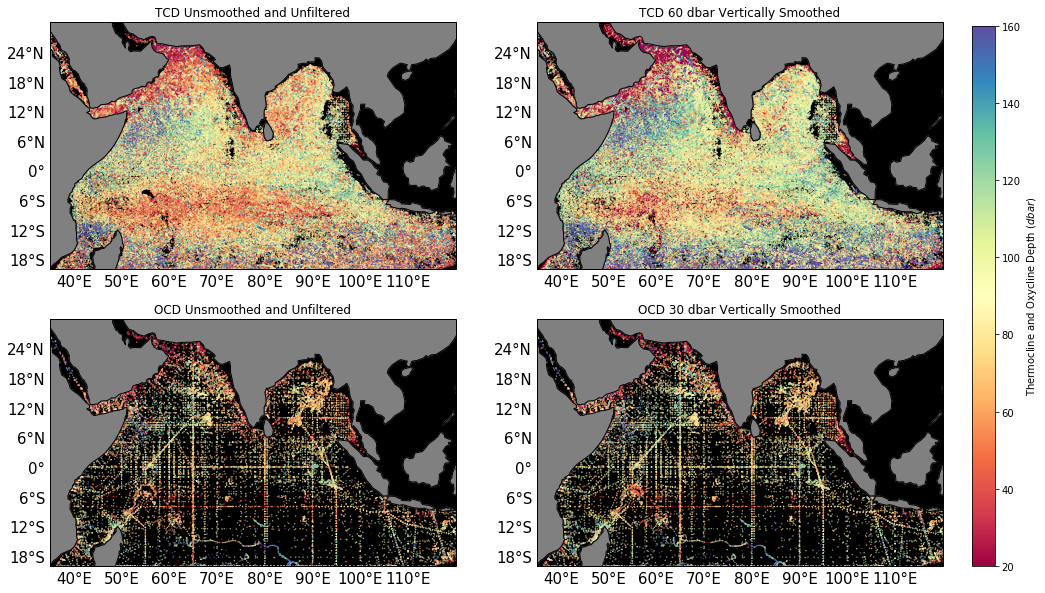

In [38]:
# Plotting Full Indian Ocean

# limits 
cmin = 20
cmax = 160
bounds = [35,120,-20,30]
sz = .5
cmap = plt.cm.Spectral # plt.cm.PuOr

fig, axes = plt.subplots(nrows = 2, ncols = 2,figsize=(16,10),subplot_kw={'projection': ccrs.PlateCarree()})

p = axes[0,0].scatter(ds_CD.lon,ds_CD.lat,s=sz,marker = '.',c=ds_CD.TCD_AWG,cmap=cmap,vmin=cmin,vmax=cmax,
                       transform=ccrs.PlateCarree())
add_land(axes[0,0],bounds)
axes[0,0].set_title('TCD Unsmoothed and Unfiltered')
axes[0,0].set_xlabel('Longitude')
axes[0,0].set_ylabel('Latitude')


p2 = axes[0,1].scatter(ds_CD.lon,ds_CD.lat,s=sz,marker = '.',c=ds_CD.TCD_sm_10_AWG,cmap=cmap, vmin=cmin,vmax=cmax,
                       transform=ccrs.PlateCarree())
add_land(axes[0,1],bounds)
axes[0,1].set_title('TCD 60 dbar Vertically Smoothed')
axes[0,1].set_xlabel('Longitude')

p4 = axes[1,0].scatter(ds_CD.lon,ds_CD.lat,s=sz,marker = '.',c=ds_CD.OCD_AWG,cmap=cmap,vmin=cmin,vmax=cmax,
                       transform=ccrs.PlateCarree())
add_land(axes[1,0],bounds)
axes[1,0].set_title('OCD Unsmoothed and Unfiltered')
axes[1,0].set_xlabel('Longitude')
axes[1,0].set_ylabel('Latitude')


p5 = axes[1,1].scatter(ds_CD.lon,ds_CD.lat,s=sz,marker = '.',c=ds_CD.OCD_sm_10_AWG,cmap=cmap, vmin=cmin,vmax=cmax,
                       transform=ccrs.PlateCarree())
add_land(axes[1,1],bounds)
axes[1,1].set_title('OCD 30 dbar Vertically Smoothed')
axes[1,1].set_xlabel('Longitude')


cbar_ax = fig.add_axes([0.925, 0.125, 0.02, 0.75])
cbar = fig.colorbar(p,cax=cbar_ax, pad=0.04)
cbar.set_label('Thermocline and Oxycline Depth ($dbar$)')



## <font color='orange'>WOA</font> 

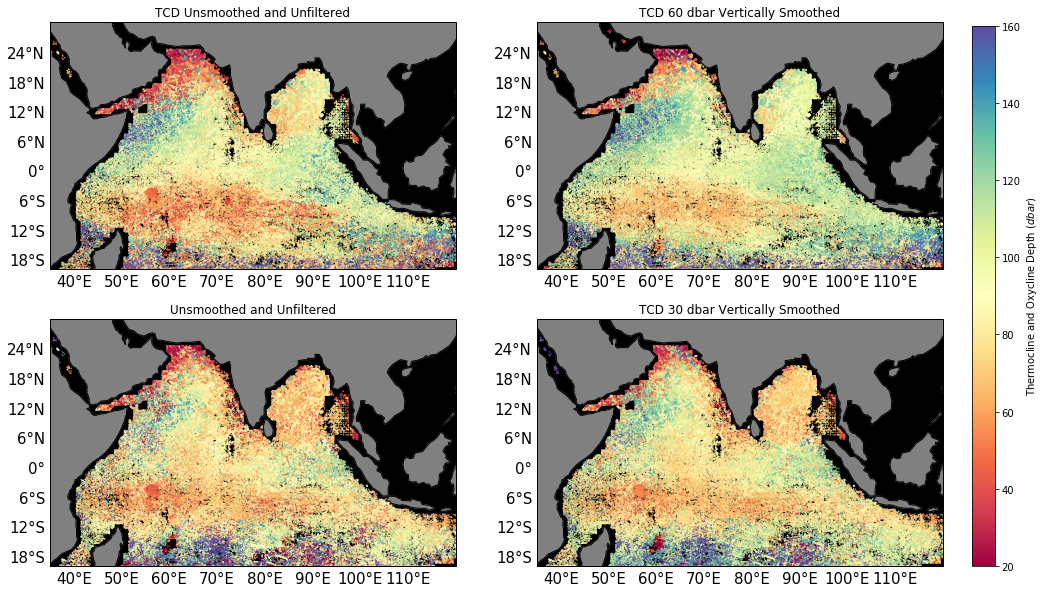

In [39]:
# limits 
cmin = 20
cmax = 160
bounds = [35,120,-20,30]
sz = .5
cmap = plt.cm.Spectral # plt.cm.PuOr

fig, axes = plt.subplots(nrows = 2, ncols = 2,figsize=(16,10),subplot_kw={'projection': ccrs.PlateCarree()})

p = axes[0,0].scatter(ds_CD.lon,ds_CD.lat,s=sz,marker = '.',c=ds_CD.TCD_WOA,cmap=cmap,vmin=cmin,vmax=cmax,
                       transform=ccrs.PlateCarree())
add_land(axes[0,0],bounds)
axes[0,0].set_title('TCD Unsmoothed and Unfiltered')
axes[0,0].set_xlabel('Longitude')
axes[0,0].set_ylabel('Latitude')


p2 = axes[0,1].scatter(ds_CD.lon,ds_CD.lat,s=sz,marker = '.',c=ds_CD.TCD_sm_10_WOA,cmap=cmap, vmin=cmin,vmax=cmax,
                       transform=ccrs.PlateCarree())
add_land(axes[0,1],bounds)
axes[0,1].set_title('TCD 60 dbar Vertically Smoothed')
axes[0,1].set_xlabel('Longitude')

p4 = axes[1,0].scatter(ds_CD.lon,ds_CD.lat,s=sz,marker = '.',c=ds_CD.OCD_WOA,cmap=cmap,vmin=cmin,vmax=cmax,
                       transform=ccrs.PlateCarree())
add_land(axes[1,0],bounds)
axes[1,0].set_title('Unsmoothed and Unfiltered')
axes[1,0].set_xlabel('Longitude')
axes[1,0].set_ylabel('Latitude')


p5 = axes[1,1].scatter(ds_CD.lon,ds_CD.lat,s=sz,marker = '.',c=ds_CD.OCD_sm_10_WOA,cmap=cmap, vmin=cmin,vmax=cmax,
                       transform=ccrs.PlateCarree())
add_land(axes[1,1],bounds)
axes[1,1].set_title('TCD 30 dbar Vertically Smoothed')
axes[1,1].set_xlabel('Longitude')


cbar_ax = fig.add_axes([0.925, 0.125, 0.02, 0.75])
cbar = fig.colorbar(p,cax=cbar_ax, pad=0.04)
cbar.set_label('Thermocline and Oxycline Depth ($dbar$)')




## <font color='orange'>TCD Anomalies</font> 

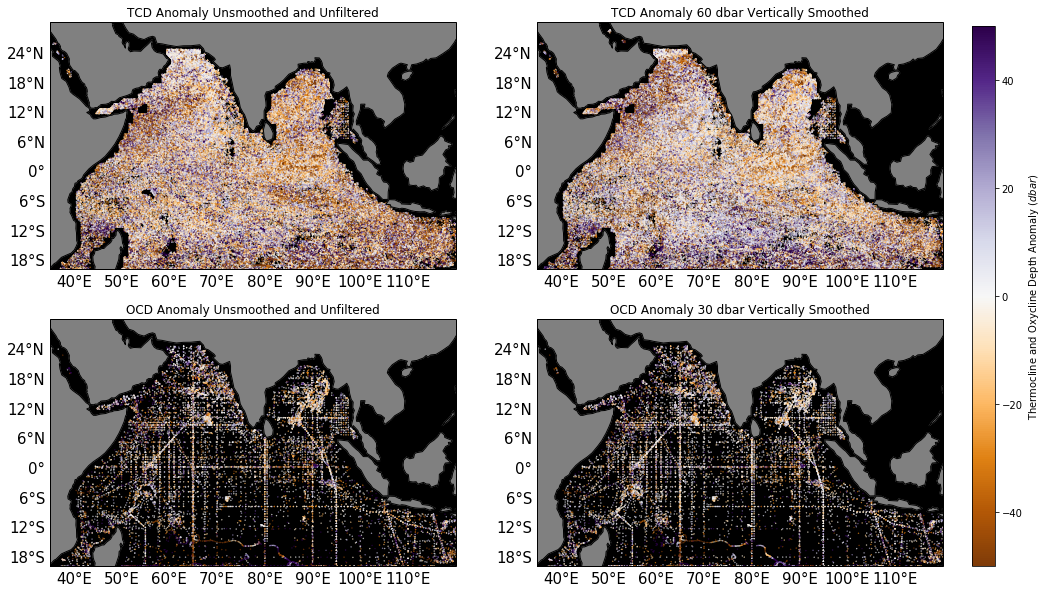

In [40]:
# Plotting Full Indian Ocean

# limits 
cmin = -50
cmax = 50
bounds = [35,120,-20,30]
sz = .5
cmap = plt.cm.PuOr

fig, axes = plt.subplots(nrows = 2, ncols = 2,figsize=(16,10),subplot_kw={'projection': ccrs.PlateCarree()})

p = axes[0,0].scatter(ds_CD.lon,ds_CD.lat,s=sz,marker = '.',c=ds_CD.TCD_anom,cmap=cmap,vmin=cmin,vmax=cmax,
                       transform=ccrs.PlateCarree())
add_land(axes[0,0],bounds)
axes[0,0].set_title('TCD Anomaly Unsmoothed and Unfiltered')
axes[0,0].set_xlabel('Longitude')
axes[0,0].set_ylabel('Latitude')


p2 = axes[0,1].scatter(ds_CD.lon,ds_CD.lat,s=sz,marker = '.',c=ds_CD.TCD_sm_10_anom,cmap=cmap, vmin=cmin,vmax=cmax,
                       transform=ccrs.PlateCarree())
add_land(axes[0,1],bounds)
axes[0,1].set_title('TCD Anomaly 60 dbar Vertically Smoothed')
axes[0,1].set_xlabel('Longitude')

p4 = axes[1,0].scatter(ds_CD.lon,ds_CD.lat,s=sz,marker = '.',c=ds_CD.OCD_anom,cmap=cmap,vmin=cmin,vmax=cmax,
                       transform=ccrs.PlateCarree())
add_land(axes[1,0],bounds)
axes[1,0].set_title('OCD Anomaly Unsmoothed and Unfiltered')
axes[1,0].set_xlabel('Longitude')
axes[1,0].set_ylabel('Latitude')


p5 = axes[1,1].scatter(ds_CD.lon,ds_CD.lat,s=sz,marker = '.',c=ds_CD.OCD_sm_10_anom,cmap=cmap, vmin=cmin,vmax=cmax,
                       transform=ccrs.PlateCarree())
add_land(axes[1,1],bounds)
axes[1,1].set_title('OCD Anomaly 30 dbar Vertically Smoothed')
axes[1,1].set_xlabel('Longitude')


cbar_ax = fig.add_axes([0.925, 0.125, 0.02, 0.75])
cbar = fig.colorbar(p,cax=cbar_ax, pad=0.04)
cbar.set_label('Thermocline and Oxycline Depth Anomaly ($dbar$)')

# <font color='darkblue'>Binned Maps</font> 

https://stackoverflow.com/questions/40465026/groupby-bins-on-two-variables

## <font color='orange'>Merged</font> 

/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: Mean of empty slice


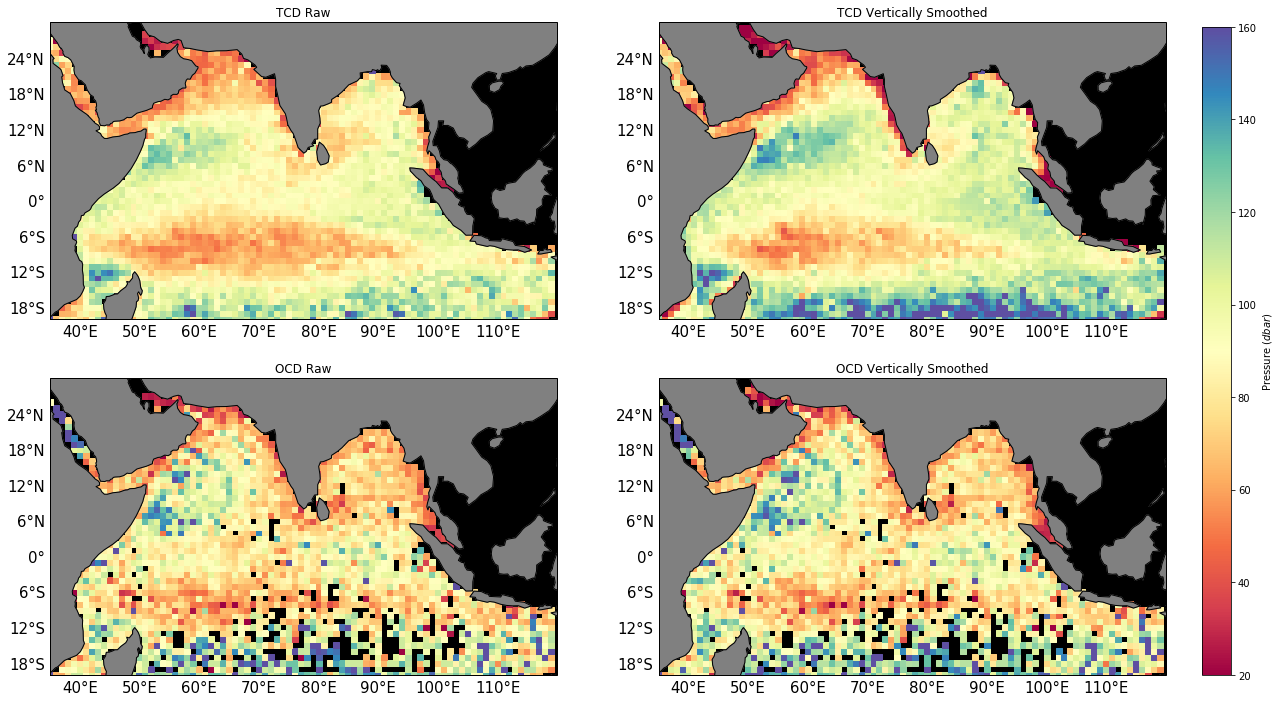

In [42]:
binwidth = 1
bounds = [35,120,-20,30]

# TCD/OCD Binned
TCD_binned_ave_AWG,TCD_bincounts_AWG,latbins,lonbins = latlonbin(ds_CD.TCD_AWG,ds_CD.lat,ds_CD.lon,bounds,binwidth)
OCD_binned_ave_AWG,OCD_bincounts_AWG,_,_ = latlonbin(ds_CD.OCD_AWG,ds_CD.lat,ds_CD.lon,bounds,binwidth)

TCD_sm_10_binned_ave_AWG,TCD_sm_10_bincounts_AWG,_,_ = latlonbin(ds_CD.TCD_sm_10_AWG,ds_CD.lat,ds_CD.lon,bounds,binwidth)
OCD_sm_10_binned_ave_AWG,OCD_sm_10_bincounts_AWG,_,_ = latlonbin(ds_CD.OCD_sm_10_AWG,ds_CD.lat,ds_CD.lon,bounds,binwidth)
    
# add to dataset
ds_CD['TCD_binned_ave_AWG'] = xr.DataArray(TCD_binned_ave_AWG,
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])

ds_CD['OCD_binned_ave_AWG'] = xr.DataArray(OCD_binned_ave_AWG,
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])

ds_CD['TCD_bincounts_AWG'] = xr.DataArray(TCD_bincounts_AWG,
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])

ds_CD['OCD_bincounts_AWG'] = xr.DataArray(OCD_bincounts_AWG,
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])

# add to dataset
ds_CD['TCD_sm_10_binned_ave_AWG'] = xr.DataArray(TCD_sm_10_binned_ave_AWG,
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])

ds_CD['OCD_sm_10_binned_ave_AWG'] = xr.DataArray(OCD_sm_10_binned_ave_AWG,
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])

ds_CD['TCD_sm_10_bincounts_AWG'] = xr.DataArray(TCD_sm_10_bincounts_AWG,
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])

ds_CD['OCD_sm_10_bincounts_AWG'] = xr.DataArray(OCD_sm_10_bincounts_AWG,
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])

# Plotting

xx,yy = np.meshgrid(ds_CD.lonbins,ds_CD.latbins)
xx = xx.flatten()
yy = yy.flatten()

# limits
cmin = 20
cmax =160
bounds = [35,120,-20,30]
s = 20
cmap = plt.cm.Spectral # plt.cm.PuOr

fig, axes = plt.subplots(nrows = 2, ncols = 2,figsize=(20,12),subplot_kw={'projection': ccrs.PlateCarree()})

p = axes[0,0].scatter(xx,yy,c = ds_CD.TCD_binned_ave_AWG.stack(z=('latbins','lonbins')),marker='s',
                      cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
# p = axes[0,0].pcolor(lonp,latp,ds_AWG.TCD_binned_ave,cmap=cmap,vmin=cmin,vmax=cmax,
#                        transform=ccrs.PlateCarree())
add_land(axes[0,0],bounds)
axes[0,0].set_extent(bounds, crs=ccrs.PlateCarree())
axes[0,0].set_title('TCD Raw')
axes[0,0].set_xlabel('Longitude')
axes[0,0].set_ylabel('Latitude')

p2 = axes[0,1].scatter(xx,yy,c = ds_CD.TCD_sm_10_binned_ave_AWG.stack(z=('latbins','lonbins')),marker='s',
                      cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
# p2 = axes[0,1].pcolormesh(lonp,latp,ds_AWG.TCD_sm_10_binned_ave,cmap=cmap, vmin=cmin,vmax=cmax,
#                        transform=ccrs.PlateCarree())
add_land(axes[0,1],bounds)
axes[0,1].set_title('TCD Vertically Smoothed')
axes[0,1].set_xlabel('Longitude')

p3 = axes[1,0].scatter(xx,yy,c = ds_CD.OCD_binned_ave_AWG.stack(z=('latbins','lonbins')),marker='s',
                      cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
# p4 = axes[1,0].pcolormesh(lonp,latp,ds_AWG.OCD_binned_ave,cmap=cmap,vmin=cmin,vmax=cmax)
add_land(axes[1,0],bounds)
axes[1,0].set_extent(bounds, crs=ccrs.PlateCarree())
axes[1,0].set_title('OCD Raw')
axes[1,0].set_xlabel('Longitude')
axes[1,0].set_ylabel('Latitude')

p4 = axes[1,1].scatter(xx,yy,c = ds_CD.OCD_sm_10_binned_ave_AWG.stack(z=('latbins','lonbins')),marker='s',
                      cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
# p5 = axes[1,1].pcolormesh(lonp,latp,ds_AWG.OCD_sm_10_binned_ave,cmap=cmap, vmin=cmin,vmax=cmax,
#                        transform=ccrs.PlateCarree())
add_land(axes[1,1],bounds)
axes[1,1].set_title('OCD Vertically Smoothed')
axes[1,1].set_xlabel('Longitude')


cbar_ax = fig.add_axes([0.925, 0.125, 0.02, 0.75])
cbar = fig.colorbar(p,cax=cbar_ax, pad=0.04)
cbar.set_label('Pressure ($dbar$)')


## <font color='orange'>WOA</font> 

/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: Mean of empty slice


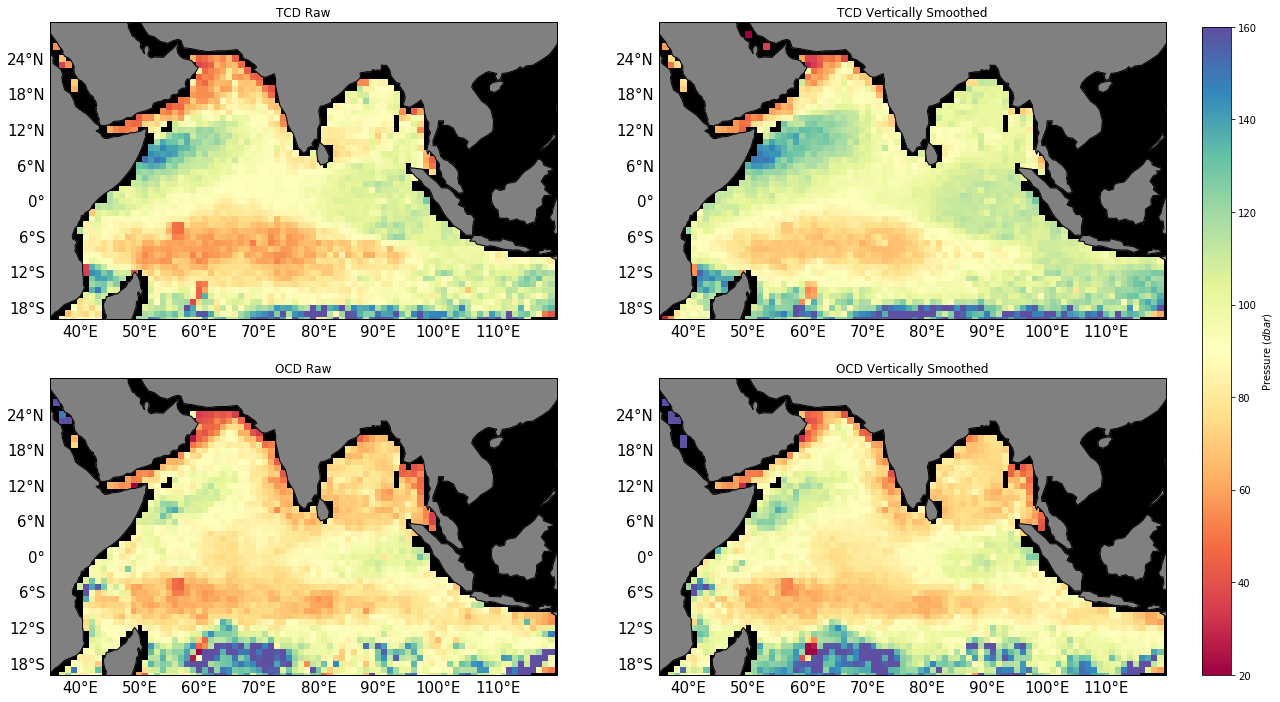

In [44]:
binwidth = 1
bounds = [35,120,-20,30]

# TCD/OCD Binned
TCD_binned_ave_WOA, TCD_bincounts_WOA,latbins_WOA,lonbins_WOA = latlonbin(ds_CD.TCD_WOA,ds_CD.lat,ds_CD.lon,bounds,binwidth)
OCD_binned_ave_WOA,OCD_bincounts_WOA,_,_ = latlonbin(ds_CD.OCD_WOA,ds_CD.lat,ds_CD.lon,bounds,binwidth)

TCD_sm_10_binned_ave_WOA,TCD_sm_10_bincounts_WOA,_,_ = latlonbin(ds_CD.TCD_sm_10_WOA,ds_CD.lat,ds_CD.lon,bounds,binwidth)
OCD_sm_10_binned_ave_WOA,OCD_sm_10_bincounts_WOA,_,_ = latlonbin(ds_CD.OCD_sm_10_WOA,ds_CD.lat,ds_CD.lon,bounds,binwidth)
    
# add to dataset
ds_CD['TCD_binned_ave_WOA'] = xr.DataArray(TCD_binned_ave_WOA,
                                   dims = ['latbins','lonbins'],coords =[latbins_WOA,lonbins_WOA])

ds_CD['OCD_binned_ave_WOA'] = xr.DataArray(OCD_binned_ave_WOA,
                                   dims = ['latbins','lonbins'],coords =[latbins_WOA,lonbins_WOA])

ds_CD['TCD_bincounts_WOA'] = xr.DataArray(TCD_bincounts_WOA,
                                   dims = ['latbins','lonbins'],coords =[latbins_WOA,lonbins_WOA])

ds_CD['OCD_bincounts_WOA'] = xr.DataArray(OCD_bincounts_WOA,
                                   dims = ['latbins','lonbins'],coords =[latbins_WOA,lonbins_WOA])

# add to dataset
ds_CD['TCD_sm_10_binned_ave_WOA'] = xr.DataArray(TCD_sm_10_binned_ave_WOA,
                                   dims = ['latbins','lonbins'],coords =[latbins_WOA,lonbins_WOA])

ds_CD['OCD_sm_10_binned_ave_WOA'] = xr.DataArray(OCD_sm_10_binned_ave_WOA,
                                   dims = ['latbins','lonbins'],coords =[latbins_WOA,lonbins_WOA])

ds_CD['TCD_sm_10_bincounts_WOA'] = xr.DataArray(TCD_sm_10_bincounts_WOA,
                                   dims = ['latbins','lonbins'],coords =[latbins_WOA,lonbins_WOA])

ds_WOA['OCD_sm_10_bincounts_WOA'] = xr.DataArray(OCD_sm_10_bincounts_WOA,
                                   dims = ['latbins','lonbins'],coords =[latbins_WOA,lonbins_WOA])

# Plotting

xx,yy = np.meshgrid(ds_CD.lonbins,ds_CD.latbins)
xx = xx.flatten()
yy = yy.flatten()

# limits
cmin = 20
cmax =160
bounds = [35,120,-20,30]
s = 20
cmap = plt.cm.Spectral # plt.cm.PuOr

fig, axes = plt.subplots(nrows = 2, ncols = 2,figsize=(20,12),subplot_kw={'projection': ccrs.PlateCarree()})

p = axes[0,0].scatter(xx,yy,c = ds_CD.TCD_binned_ave_WOA.stack(z=('latbins','lonbins')),marker='s',
                      cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
# p = axes[0,0].pcolor(lonp,latp,ds_AWG.TCD_binned_ave,cmap=cmap,vmin=cmin,vmax=cmax,
#                        transform=ccrs.PlateCarree())
add_land(axes[0,0],bounds)
axes[0,0].set_extent(bounds, crs=ccrs.PlateCarree())
axes[0,0].set_title('TCD Raw')
axes[0,0].set_xlabel('Longitude')
axes[0,0].set_ylabel('Latitude')

p2 = axes[0,1].scatter(xx,yy,c = ds_CD.TCD_sm_10_binned_ave_WOA.stack(z=('latbins','lonbins')),marker='s',
                      cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
# p2 = axes[0,1].pcolormesh(lonp,latp,ds_AWG.TCD_sm_10_binned_ave,cmap=cmap, vmin=cmin,vmax=cmax,
#                        transform=ccrs.PlateCarree())
add_land(axes[0,1],bounds)
axes[0,1].set_title('TCD Vertically Smoothed')
axes[0,1].set_xlabel('Longitude')

p3 = axes[1,0].scatter(xx,yy,c = ds_CD.OCD_binned_ave_WOA.stack(z=('latbins','lonbins')),marker='s',
                      cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
# p4 = axes[1,0].pcolormesh(lonp,latp,ds_AWG.OCD_binned_ave,cmap=cmap,vmin=cmin,vmax=cmax)
add_land(axes[1,0],bounds)
axes[1,0].set_extent(bounds, crs=ccrs.PlateCarree())
axes[1,0].set_title('OCD Raw')
axes[1,0].set_xlabel('Longitude')
axes[1,0].set_ylabel('Latitude')

p4 = axes[1,1].scatter(xx,yy,c = ds_CD.OCD_sm_10_binned_ave_WOA.stack(z=('latbins','lonbins')),marker='s',
                      cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
# p5 = axes[1,1].pcolormesh(lonp,latp,ds_AWG.OCD_sm_10_binned_ave,cmap=cmap, vmin=cmin,vmax=cmax,
#                        transform=ccrs.PlateCarree())
add_land(axes[1,1],bounds)
axes[1,1].set_title('OCD Vertically Smoothed')
axes[1,1].set_xlabel('Longitude')


cbar_ax = fig.add_axes([0.925, 0.125, 0.02, 0.75])
cbar = fig.colorbar(p,cax=cbar_ax, pad=0.04)
cbar.set_label('Pressure ($dbar$)')

## <font color='orange'>Anomaly</font> 

/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: Mean of empty slice


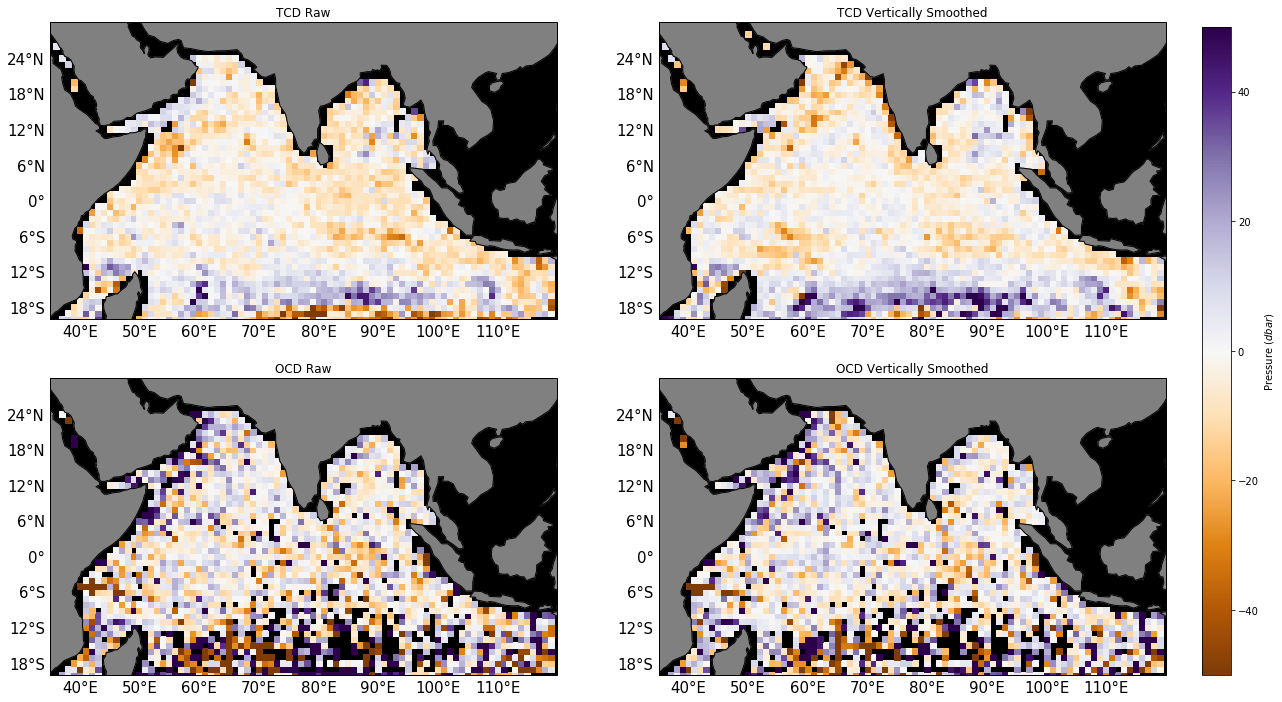

In [46]:
binwidth = 1
bounds = [35,120,-20,30]

# TCD/OCD Binned
TCD_anom_binned_ave, TCD_anom_bincounts,latbins,lonbins = latlonbin(ds_CD.TCD_anom,ds_CD.lat,ds_CD.lon,bounds,binwidth)
OCD_anom_binned_ave, OCD_anom_bincounts,_,_ = latlonbin(ds_CD.OCD_anom,ds_CD.lat,ds_CD.lon,bounds,binwidth)

TCD_sm_10_anom_binned_ave,TCD_sm_10_anom_bincounts,_,_ = latlonbin(ds_CD.TCD_sm_10_anom,ds_CD.lat,ds_CD.lon,bounds,binwidth)
OCD_sm_10_anom_binned_ave,OCD_sm_10_anom_bincounts,_,_ = latlonbin(ds_CD.OCD_sm_10_anom,ds_CD.lat,ds_CD.lon,bounds,binwidth)
    
# add to dataset
ds_CD['TCD_anom_binned_ave'] = xr.DataArray(TCD_anom_binned_ave,
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])

ds_CD['OCD_anom_binned_ave'] = xr.DataArray(OCD_anom_binned_ave,
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])

ds_CD['TCD_anom_bincounts'] = xr.DataArray(TCD_anom_bincounts,
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])

ds_CD['OCD_anom_bincounts'] = xr.DataArray(OCD_anom_bincounts,
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])

# add to dataset
ds_CD['TCD_sm_10_anom_binned_ave'] = xr.DataArray(TCD_sm_10_anom_binned_ave,
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])

ds_CD['OCD_sm_10_anom_binned_ave'] = xr.DataArray(OCD_sm_10_anom_binned_ave,
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])

ds_CD['TCD_sm_10_anom_bincounts'] = xr.DataArray(TCD_sm_10_anom_bincounts,
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])

ds_CD['OCD_sm_10_anom_bincounts'] = xr.DataArray(OCD_sm_10_anom_bincounts,
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])

# Plotting

xx,yy = np.meshgrid(ds_CD.lonbins,ds_CD.latbins)
xx = xx.flatten()
yy = yy.flatten()

# limits
cmin = -50
cmax = 50
bounds = [35,120,-20,30]
s = 20
cmap = plt.cm.PuOr

fig, axes = plt.subplots(nrows = 2, ncols = 2,figsize=(20,12),subplot_kw={'projection': ccrs.PlateCarree()})

p = axes[0,0].scatter(xx,yy,c = ds_CD.TCD_anom_binned_ave.stack(z=('latbins','lonbins')),marker='s',
                      cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
# p = axes[0,0].pcolor(lonp,latp,ds_AWG.TCD_binned_ave,cmap=cmap,vmin=cmin,vmax=cmax,
#                        transform=ccrs.PlateCarree())
add_land(axes[0,0],bounds)
axes[0,0].set_extent(bounds, crs=ccrs.PlateCarree())
axes[0,0].set_title('TCD Raw')
axes[0,0].set_xlabel('Longitude')
axes[0,0].set_ylabel('Latitude')

p2 = axes[0,1].scatter(xx,yy,c = ds_CD.TCD_sm_10_anom_binned_ave.stack(z=('latbins','lonbins')),marker='s',
                      cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
# p2 = axes[0,1].pcolormesh(lonp,latp,ds_AWG.TCD_sm_10_binned_ave,cmap=cmap, vmin=cmin,vmax=cmax,
#                        transform=ccrs.PlateCarree())
add_land(axes[0,1],bounds)
axes[0,1].set_title('TCD Vertically Smoothed')
axes[0,1].set_xlabel('Longitude')

p3 = axes[1,0].scatter(xx,yy,c = ds_CD.OCD_anom_binned_ave.stack(z=('latbins','lonbins')),marker='s',
                      cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
# p4 = axes[1,0].pcolormesh(lonp,latp,ds_AWG.OCD_binned_ave,cmap=cmap,vmin=cmin,vmax=cmax)
add_land(axes[1,0],bounds)
axes[1,0].set_extent(bounds, crs=ccrs.PlateCarree())
axes[1,0].set_title('OCD Raw')
axes[1,0].set_xlabel('Longitude')
axes[1,0].set_ylabel('Latitude')

p4 = axes[1,1].scatter(xx,yy,c = ds_CD.OCD_sm_10_anom_binned_ave.stack(z=('latbins','lonbins')),marker='s',
                      cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
# p5 = axes[1,1].pcolormesh(lonp,latp,ds_AWG.OCD_sm_10_binned_ave,cmap=cmap, vmin=cmin,vmax=cmax,
#                        transform=ccrs.PlateCarree())
add_land(axes[1,1],bounds)
axes[1,1].set_title('OCD Vertically Smoothed')
axes[1,1].set_xlabel('Longitude')


cbar_ax = fig.add_axes([0.925, 0.125, 0.02, 0.75])
cbar = fig.colorbar(p,cax=cbar_ax, pad=0.04)
cbar.set_label('Pressure ($dbar$)')



# <font color='darkblue'>Month of Minimum Oxygen/OCD</font> 

## <font color='orange'>Month of Minimum Oxygen</font> 

In [ ]:
# min_doxy,min_doxy_month,min_doxy_TCD,min_doxy_OCD,latbins,lonbins = latlonbin_min_doxy(np.nanmean(ds_AWG.doxy,1),
#                                                                                       ds_AWG.OCD,ds_AWG.TCD,
#                                                                                       ds_AWG.lat,ds_AWG.lon,
#                                                                                       bounds,binwidth)
# min_doxy_upper,min_doxy_upper_month,min_doxy_upper_TCD,min_doxy_upper_OCD,_,_ = latlonbin_min_doxy(ds_AWG.doxy_upper_mean,
#                                                                                       ds_AWG.OCD,ds_AWG.TCD,
#                                                                                       ds_AWG.lat,ds_AWG.lon,
#                                                                                       bounds,binwidth)

# min_doxy_lower,min_doxy_lower_month,min_doxy_lower_TCD,min_doxy_lower_OCD,_,_ = latlonbin_min_doxy(ds_AWG.doxy_lower_mean,
#                                                                                       ds_AWG.OCD,ds_AWG.TCD,
#                                                                                       ds_AWG.lat,ds_AWG.lon,
#                                                                                       bounds,binwidth)                                                                                                             

# min_doxy_TC,min_doxy_TC_month,min_doxy_TC_TCD,min_doxy_TC_OCD,_,_ = latlonbin_min_doxy(ds_AWG.doxy_TC_mean,
#                                                                                       ds_AWG.OCD,ds_AWG.TCD,
#                                                                                       ds_AWG.lat,ds_AWG.lon,
#                                                                                       bounds,binwidth)       

# # add to dataset
# ds_AWG['min_doxy'] = xr.DataArray(min_doxy,
#                                    dims = ['latbins','lonbins'],coords =[latbins,lonbins])
# ds_AWG['min_doxy_month'] = xr.DataArray(min_doxy_month,
#                                    dims = ['latbins','lonbins'],coords =[latbins,lonbins])
# ds_AWG['min_doxy_TCD'] = xr.DataArray(min_doxy_TCD,
#                                    dims = ['latbins','lonbins'],coords =[latbins,lonbins])
# ds_AWG['min_doxy_OCD'] = xr.DataArray(min_doxy_OCD,
#                                    dims = ['latbins','lonbins'],coords =[latbins,lonbins])

# ds_AWG['min_doxy_upper'] = xr.DataArray(min_doxy_upper,
#                                    dims = ['latbins','lonbins'],coords =[latbins,lonbins])
# ds_AWG['min_doxy_upper_month'] = xr.DataArray(min_doxy_upper_month,
#                                    dims = ['latbins','lonbins'],coords =[latbins,lonbins])
# ds_AWG['min_doxy_upper_TCD'] = xr.DataArray(min_doxy_upper_TCD,
#                                    dims = ['latbins','lonbins'],coords =[latbins,lonbins])
# ds_AWG['min_doxy_upper_OCD'] = xr.DataArray(min_doxy_upper_OCD,
#                                    dims = ['latbins','lonbins'],coords =[latbins,lonbins])

# ds_AWG['min_doxy_lower'] = xr.DataArray(min_doxy_lower,
#                                    dims = ['latbins','lonbins'],coords =[latbins,lonbins])
# ds_AWG['min_doxy_lower_month'] = xr.DataArray(min_doxy_lower_month,
#                                    dims = ['latbins','lonbins'],coords =[latbins,lonbins])
# ds_AWG['min_doxy_lower_TCD'] = xr.DataArray(min_doxy_lower_TCD,
#                                    dims = ['latbins','lonbins'],coords =[latbins,lonbins])
# ds_AWG['min_doxy_lower_OCD'] = xr.DataArray(min_doxy_lower_OCD,
#                                    dims = ['latbins','lonbins'],coords =[latbins,lonbins])

# ds_AWG['min_doxy_TC'] = xr.DataArray(min_doxy_TC,
#                                    dims = ['latbins','lonbins'],coords =[latbins,lonbins])
# ds_AWG['min_doxy_TC_month'] = xr.DataArray(min_doxy_TC_month,
#                                    dims = ['latbins','lonbins'],coords =[latbins,lonbins])
# ds_AWG['min_doxy_TC_TCD'] = xr.DataArray(min_doxy_TC_TCD,
#                                    dims = ['latbins','lonbins'],coords =[latbins,lonbins])
# ds_AWG['min_doxy_TC_OCD'] = xr.DataArray(min_doxy_TC_OCD,
#                                    dims = ['latbins','lonbins'],coords =[latbins,lonbins])

In [ ]:
# # Plotting
# xx,yy = np.meshgrid(ds_AWG.lonbins,ds_AWG.latbins)
# xx = xx.flatten()
# yy = yy.flatten()

# bounds = [35,120,-20,30]
# s = 20

# fig, axes = plt.subplots(nrows = 1, ncols = 2,figsize=(20,4),subplot_kw={'projection': ccrs.PlateCarree()})


# # # total o2

# # # limits
# # cmin = 50
# # cmax = 200
# # cmap = plt.cm.Spectral
# # p = axes[0,0].scatter(xx,yy,c = ds_AWG.min_doxy.stack(z=('latbins','lonbins')),marker='s',
# #                       cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
# # add_land(axes[0,0],bounds)
# # axes[0,0].set_extent(bounds, crs=ccrs.PlateCarree())
# # axes[0,0].set_title('Minimum Mean [O2] Total Water Column')
# # cbar = fig.colorbar(p,ax=axes[0,0], pad=0.04)
# # cbar.set_label('Dissolved Oxygen ($units$)')

# # # limits
# # cmin = 1
# # cmax = 12
# # cmap = plt.cm.twilight_shifted
# # p2 = axes[0,1].scatter(xx,yy,c = ds_AWG.min_doxy_month.stack(z=('latbins','lonbins')),marker='s',
# #                       cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
# # add_land(axes[0,1],bounds)
# # axes[0,1].set_title('Month of Minimum [O2]')
# # cbar = fig.colorbar(p2,ax=axes[0,1], pad=0.04)
# # cbar.set_ticks(np.linspace(0,12,13))
# # cbar.set_ticklabels(['dec','jan','feb','mar','apr','may','jun',
# #                     'jul','aug','sep','oct','nov','dec'])
# # cbar.set_label('month')


# # # upper 50 dbar

# # # limits
# # cmin = 50
# # cmax = 200
# # cmap = plt.cm.Spectral
# # p3 = axes[1,0].scatter(xx,yy,c = ds_AWG.min_doxy_upper.stack(z=('latbins','lonbins')),marker='s',
# #                       cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
# # add_land(axes[1,0],bounds)
# # axes[1,0].set_extent(bounds, crs=ccrs.PlateCarree())
# # axes[1,0].set_title('Minimum Mean [O2] 0-50 dbar')
# # cbar = fig.colorbar(p3,ax=axes[1,0], pad=0.04)
# # cbar.set_label('Dissolved Oxygen ($units$)')

# # cmin = 1
# # cmax = 12
# # cmap = plt.cm.twilight_shifted
# # p4 = axes[1,1].scatter(xx,yy,c = ds_AWG.min_doxy_upper_month.stack(z=('latbins','lonbins')),marker='s',
# #                       cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
# # add_land(axes[1,1],bounds)
# # axes[1,1].set_title('Month of Minimum [O2] 0-50 dbar')
# # cbar = fig.colorbar(p4,ax=axes[1,1], pad=0.04)
# # cbar.set_ticks(np.linspace(0,12,13))
# # cbar.set_ticklabels(['dec','jan','feb','mar','apr','may','jun',
# #                     'jul','aug','sep','oct','nov','dec'])
# # cbar.set_label('month')


# # # 50-200 dbar

# # # limits
# # cmin = 50
# # cmax = 200
# # cmap = plt.cm.Spectral
# # p5 = axes[2,0].scatter(xx,yy,c = ds_AWG.min_doxy_lower.stack(z=('latbins','lonbins')),marker='s',
# #                       cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
# # add_land(axes[2,0],bounds)
# # axes[2,0].set_extent(bounds, crs=ccrs.PlateCarree())
# # axes[2,0].set_title('Minimum Mean [O2] 50-200 dbar')
# # cbar = fig.colorbar(p5,ax=axes[2,0], pad=0.04)
# # cbar.set_label('Dissolved Oxygen ($units$)')

# # cmin = 1
# # cmax = 12
# # cmap = plt.cm.twilight_shifted
# # p6 = axes[2,1].scatter(xx,yy,c = ds_AWG.min_doxy_lower_month.stack(z=('latbins','lonbins')),marker='s',
# #                       cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
# # add_land(axes[2,1],bounds)
# # axes[2,1].set_title('Month of Minimum [O2] 50-200 dbar')
# # cbar = fig.colorbar(p6,ax=axes[2,1], pad=0.04)
# # cbar.set_ticks(np.linspace(0,12,13))
# # cbar.set_ticklabels(['dec','jan','feb','mar','apr','may','jun',
# #                     'jul','aug','sep','oct','nov','dec'])
# # cbar.set_label('month')

# # 0-200 dbar

# # limits
# cmin = 50
# cmax = 200
# cmap = plt.cm.Spectral
# p7 = axes[0].scatter(xx,yy,c = ds_AWG.min_doxy_TC.stack(z=('latbins','lonbins')),marker='s',
#                       cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
# add_land(axes[0],bounds)
# axes[0].set_extent(bounds, crs=ccrs.PlateCarree())
# axes[0].set_title('Minimum Mean [O2] 0-200 dbar')
# cbar = fig.colorbar(p7,ax=axes[0], pad=0.04)
# cbar.set_label('Dissolved Oxygen ($units$)')

# cmin = 1
# cmax = 12
# cmap = plt.cm.twilight_shifted
# p8 = axes[1].scatter(xx,yy,c = ds_AWG.min_doxy_TC_month.stack(z=('latbins','lonbins')),marker='s',
#                       cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
# add_land(axes[1],bounds)
# axes[1].set_title('Month of Minimum [O2] 0-200 dbar')
# cbar = fig.colorbar(p8,ax=axes[1], pad=0.04)
# cbar.set_ticks(np.linspace(0,12,13))
# cbar.set_ticklabels(['dec','jan','feb','mar','apr','may','jun',
#                     'jul','aug','sep','oct','nov','dec'])
# cbar.set_label('month')



## <font color='orange'>Month of Minimum OCD</font> 

In [ ]:
# min_OCD,min_OCD_month,min_OCD_TCD,min_OCD_doxy_upper,min_OCD_doxy_lower,latbins,lonbins = latlonbin_min_OCD(ds_AWG.OCD,ds_AWG.TCD,
#                                                                                            doxy_upper,doxy_lower,
#                                                                                            ds_AWG.lat,ds_AWG.lon,
#                                                                                            bounds,binwidth)

# # do smoothed version too


# # add to dataset
# ds_AWG['min_OCD'] = xr.DataArray(min_OCD,
#                                    dims = ['latbins','lonbins'],coords =[latbins,lonbins])
# ds_AWG['min_OCD_month'] = xr.DataArray(min_OCD_month,
#                                    dims = ['latbins','lonbins'],coords =[latbins,lonbins])
# ds_AWG['min_OCD_TCD'] = xr.DataArray(min_OCD_TCD,
#                                    dims = ['latbins','lonbins'],coords =[latbins,lonbins])
# ds_AWG['min_OCD_doxy_upper'] = xr.DataArray(min_OCD_doxy_upper,
#                                    dims = ['latbins','lonbins'],coords =[latbins,lonbins])
# ds_AWG['min_OCD_doxy_lower'] = xr.DataArray(min_OCD_doxy_lower,
#                                    dims = ['latbins','lonbins'],coords =[latbins,lonbins])

In [ ]:
# # Plotting
# xx,yy = np.meshgrid(ds_AWG.lonbins,ds_AWG.latbins)
# xx = xx.flatten()
# yy = yy.flatten()

# bounds = [35,120,-20,30]
# s = 20

# fig, axes = plt.subplots(nrows = 2, ncols = 2,figsize=(20,12),subplot_kw={'projection': ccrs.PlateCarree()})

# # limits
# cmin = 20
# cmax = 160
# cmap = plt.cm.Spectral
# p = axes[0,0].scatter(xx,yy,c = ds_AWG.min_OCD.stack(z=('latbins','lonbins')),marker='s',
#                       cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
# add_land(axes[0,0],bounds)
# axes[0,0].set_extent(bounds, crs=ccrs.PlateCarree())
# axes[0,0].set_title('Minimum OCD')
# cbar = fig.colorbar(p,ax=axes[0,0], pad=0.04)
# cbar.set_label('Pressure ($dbar$)')

# # limits
# cmin = 1
# cmax = 12
# cmap = plt.cm.Spectral
# p2 = axes[0,1].scatter(xx,yy,c = ds_AWG.min_OCD_month.stack(z=('latbins','lonbins')),marker='s',
#                       cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
# add_land(axes[0,1],bounds)
# axes[0,1].set_title('Month of Minimum OCD')
# cbar = fig.colorbar(p2,ax=axes[0,1], pad=0.04)
# cbar.set_label('month')

# # limits
# cmin = 0
# cmax = 200
# cmap = plt.cm.Spectral
# p3 = axes[1,0].scatter(xx,yy,c = ds_AWG.min_OCD_doxy_upper.stack(z=('latbins','lonbins')),marker='s',
#                       cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
# add_land(axes[1,0],bounds)
# axes[1,0].set_extent(bounds, crs=ccrs.PlateCarree())
# axes[1,0].set_title('[O2] 0-50 dbar')
# cbar = fig.colorbar(p3,ax=axes[1,0], pad=0.04)
# cbar.set_label('Dissolved Oxygen ($units$)')

# cmin = 0
# cmax = 200
# cmap = plt.cm.Spectral
# p4 = axes[1,1].scatter(xx,yy,c = ds_AWG.min_OCD_doxy_lower.stack(z=('latbins','lonbins')),marker='s',
#                       cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
# add_land(axes[1,1],bounds)
# axes[1,1].set_title('[O2] 50-200 dbar')
# cbar = fig.colorbar(p4,ax=axes[1,1], pad=0.04)
# cbar.set_label('Dissolved Oxygen ($units$)')

## <font color='orange'>Month of Minimum OCD Anomaly</font> 

In [ ]:
# # find average for upper 0-50 dbar
# doxy_upper = np.array(ds_AWG.doxy[:,ds_AWG.pres<50])
# doxy_upper = np.nanmean(doxy_upper,1)

# # find average for lower 55-200 dbar 
# doxy_lower = np.array(ds_AWG.doxy[:,(ds_AWG.pres>50) & (ds_AWG.pres<200)])
# doxy_lower = np.nanmean(doxy_lower,1)

# min_OCD_anom,min_OCD_anom_month,min_OCD_anom_TCD_anom,min_OCD_anom_doxy_upper,min_OCD_anom_doxy_lower,latbins,lonbins = latlonbin_min_OCD(ds_AWG.OCD_anom,ds_AWG.TCD_anom,
#                                                                                            doxy_upper,doxy_lower,
#                                                                                            ds_AWG.lat,ds_AWG.lon,
#                                                                                            bounds,binwidth)

# # do smoothed version too


# # add to dataset
# ds_AWG['min_OCD_anom'] = xr.DataArray(min_OCD_anom,
#                                    dims = ['latbins','lonbins'],coords =[latbins,lonbins])
# ds_AWG['min_OCD_anom_month'] = xr.DataArray(min_OCD_anom_month,
#                                    dims = ['latbins','lonbins'],coords =[latbins,lonbins])
# ds_AWG['min_OCD_anom_TCD_anom'] = xr.DataArray(min_OCD_anom_TCD_anom,
#                                    dims = ['latbins','lonbins'],coords =[latbins,lonbins])
# ds_AWG['min_OCD_anom_doxy_upper'] = xr.DataArray(min_OCD_anom_doxy_upper,
#                                    dims = ['latbins','lonbins'],coords =[latbins,lonbins])
# ds_AWG['min_OCD_anom_doxy_lower'] = xr.DataArray(min_OCD_anom_doxy_lower,
#                                    dims = ['latbins','lonbins'],coords =[latbins,lonbins])


In [ ]:
# # Plotting
# xx,yy = np.meshgrid(ds_AWG.lonbins,ds_AWG.latbins)
# xx = xx.flatten()
# yy = yy.flatten()

# bounds = [35,120,-20,30]
# s = 20

# fig, axes = plt.subplots(nrows = 2, ncols = 2,figsize=(20,12),subplot_kw={'projection': ccrs.PlateCarree()})

# # limits
# cmin = -25
# cmax = 25
# cmap = plt.cm.coolwarm
# p = axes[0,0].scatter(xx,yy,c = ds_AWG.min_OCD_anom.stack(z=('latbins','lonbins')),marker='s',
#                       cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
# add_land(axes[0,0],bounds)
# axes[0,0].set_extent(bounds, crs=ccrs.PlateCarree())
# axes[0,0].set_title('Minimum OCD Anomaly')
# cbar = fig.colorbar(p,ax=axes[0,0], pad=0.04)
# cbar.set_label('Pressure ($dbar$)')

# # limits
# cmin = 1
# cmax = 12
# cmap = plt.cm.Spectral
# p2 = axes[0,1].scatter(xx,yy,c = ds_AWG.min_OCD_anom_month.stack(z=('latbins','lonbins')),marker='s',
#                       cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
# add_land(axes[0,1],bounds)
# axes[0,1].set_title('Month of Minimum OCD Anomaly')
# cbar = fig.colorbar(p2,ax=axes[0,1], pad=0.04)
# cbar.set_label('month')

# # limits
# cmin = 0
# cmax = 200
# cmap = plt.cm.Spectral
# p3 = axes[1,0].scatter(xx,yy,c = ds_AWG.min_OCD_anom_doxy_upper.stack(z=('latbins','lonbins')),marker='s',
#                       cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
# add_land(axes[1,0],bounds)
# axes[1,0].set_extent(bounds, crs=ccrs.PlateCarree())
# axes[1,0].set_title('[O2] 0-50 dbar')
# cbar = fig.colorbar(p3,ax=axes[1,0], pad=0.04)
# cbar.set_label('Dissolved Oxygen ($units$)')

# cmin = 0
# cmax = 200
# cmap = plt.cm.Spectral
# p4 = axes[1,1].scatter(xx,yy,c = ds_AWG.min_OCD_anom_doxy_lower.stack(z=('latbins','lonbins')),marker='s',
#                       cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
# add_land(axes[1,1],bounds)
# axes[1,1].set_title('[O2] 50-200 dbar')
# cbar = fig.colorbar(p4,ax=axes[1,1], pad=0.04)
# cbar.set_label('Dissolved Oxygen ($units$)')

# <font color='darkblue'>Gaussian Filtered Binned Maps</font> 

## <font color='orange'>Merged</font> 

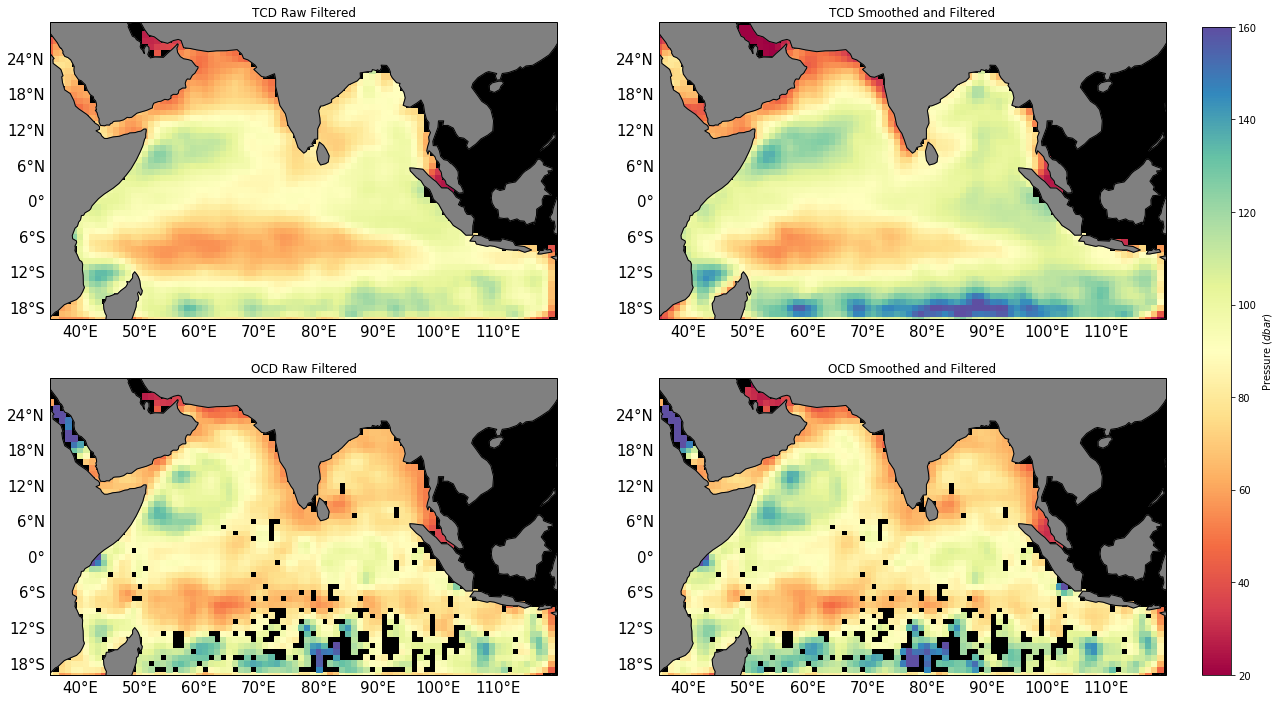

In [47]:
# add to dataset
ds_CD['TCD_binned_ave_filt_AWG'] = xr.DataArray(gaus_filter_nan(ds_CD.TCD_binned_ave_AWG,1),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])

ds_CD['OCD_binned_ave_filt_AWG'] = xr.DataArray(gaus_filter_nan(ds_CD.OCD_binned_ave_AWG,1),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])

ds_CD['TCD_sm_10_binned_ave_filt_AWG'] = xr.DataArray(gaus_filter_nan(ds_CD.TCD_sm_10_binned_ave_AWG,1),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])

ds_CD['OCD_sm_10_binned_ave_filt_AWG'] = xr.DataArray(gaus_filter_nan(ds_CD.OCD_sm_10_binned_ave_AWG,1),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])

# Plotting

xx,yy = np.meshgrid(ds_CD.lonbins,ds_CD.latbins)
xx = xx.flatten()
yy = yy.flatten()

# limits
cmin = 20
cmax = 160
bounds = [35,120,-20,30]
cmap = plt.cm.Spectral # plt.cm.PuOr

fig, axes = plt.subplots(nrows = 2, ncols = 2,figsize=(20,12),subplot_kw={'projection': ccrs.PlateCarree()})

p = axes[0,0].scatter(xx,yy,c = ds_CD.TCD_binned_ave_filt_AWG.stack(z=('latbins','lonbins')),marker='s',
                      cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
# p = axes[0,0].pcolor(lonp,latp,ds_AWG.TCD_binned_ave_filt,cmap=cmap,vmin=cmin,vmax=cmax,
#                        transform=ccrs.PlateCarree())
add_land(axes[0,0],bounds)
axes[0,0].set_extent(bounds, crs=ccrs.PlateCarree())
axes[0,0].set_title('TCD Raw Filtered')
axes[0,0].set_xlabel('Longitude')
axes[0,0].set_ylabel('Latitude')

p2 = axes[0,1].scatter(xx,yy,c = ds_CD.TCD_sm_10_binned_ave_filt_AWG.stack(z=('latbins','lonbins')),marker='s',
                      cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
# p2 = axes[0,1].pcolormesh(lonp,latp,ds_AWG.TCD_sm_10_binned_ave_filt,cmap=cmap, vmin=cmin,vmax=cmax,
#                        transform=ccrs.PlateCarree())
add_land(axes[0,1],bounds)
axes[0,1].set_title('TCD Smoothed and Filtered')
axes[0,1].set_xlabel('Longitude')

p3 = axes[1,0].scatter(xx,yy,c = ds_CD.OCD_binned_ave_filt_AWG.stack(z=('latbins','lonbins')),marker='s',
                      cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
# p4 = axes[1,0].pcolormesh(lonp,latp,ds_AWG.OCD_binned_ave_filt,cmap=cmap,vmin=cmin,vmax=cmax)
add_land(axes[1,0],bounds)
axes[1,0].set_extent(bounds, crs=ccrs.PlateCarree())
axes[1,0].set_title('OCD Raw Filtered')
axes[1,0].set_xlabel('Longitude')
axes[1,0].set_ylabel('Latitude')

p4 = axes[1,1].scatter(xx,yy,c = ds_CD.OCD_sm_10_binned_ave_filt_AWG.stack(z=('latbins','lonbins')),marker='s',
                      cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
# p5 = axes[1,1].pcolormesh(lonp,latp,ds_AWG.OCD_sm_10_binned_ave_filt,cmap=cmap, vmin=cmin,vmax=cmax,
#                        transform=ccrs.PlateCarree())
add_land(axes[1,1],bounds)
axes[1,1].set_title('OCD Smoothed and Filtered')
axes[1,1].set_xlabel('Longitude')


cbar_ax = fig.add_axes([0.925, 0.125, 0.02, 0.75])
cbar = fig.colorbar(p,cax=cbar_ax, pad=0.04)
cbar.set_label('Pressure ($dbar$)')

## <font color='orange'>WOA</font> 

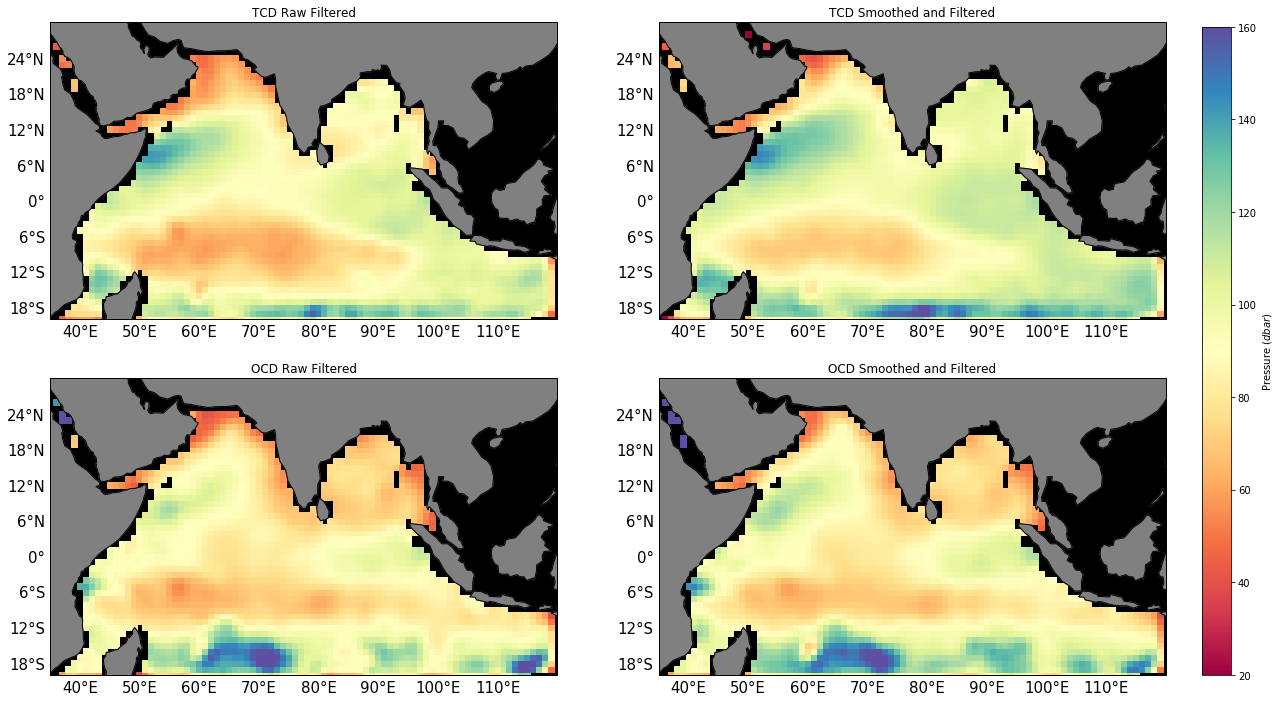

In [48]:
# add to dataset
ds_CD['TCD_binned_ave_filt_WOA'] = xr.DataArray(gaus_filter_nan(ds_CD.TCD_binned_ave_WOA,1),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])

ds_CD['OCD_binned_ave_filt_WOA'] = xr.DataArray(gaus_filter_nan(ds_CD.OCD_binned_ave_WOA,1),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])

ds_CD['TCD_sm_10_binned_ave_filt_WOA'] = xr.DataArray(gaus_filter_nan(ds_CD.TCD_sm_10_binned_ave_WOA,1),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])

ds_CD['OCD_sm_10_binned_ave_filt_WOA'] = xr.DataArray(gaus_filter_nan(ds_CD.OCD_sm_10_binned_ave_WOA,1),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])

# Plotting

xx,yy = np.meshgrid(ds_CD.lonbins,ds_CD.latbins)
xx = xx.flatten()
yy = yy.flatten()

# limits
cmin = 20
cmax = 160
bounds = [35,120,-20,30]
cmap = plt.cm.Spectral # plt.cm.PuOr

fig, axes = plt.subplots(nrows = 2, ncols = 2,figsize=(20,12),subplot_kw={'projection': ccrs.PlateCarree()})

p = axes[0,0].scatter(xx,yy,c = ds_CD.TCD_binned_ave_filt_WOA.stack(z=('latbins','lonbins')),marker='s',
                      cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
# p = axes[0,0].pcolor(lonp,latp,ds_AWG.TCD_binned_ave_filt,cmap=cmap,vmin=cmin,vmax=cmax,
#                        transform=ccrs.PlateCarree())
add_land(axes[0,0],bounds)
axes[0,0].set_extent(bounds, crs=ccrs.PlateCarree())
axes[0,0].set_title('TCD Raw Filtered')
axes[0,0].set_xlabel('Longitude')
axes[0,0].set_ylabel('Latitude')

p2 = axes[0,1].scatter(xx,yy,c = ds_CD.TCD_sm_10_binned_ave_filt_WOA.stack(z=('latbins','lonbins')),marker='s',
                      cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
# p2 = axes[0,1].pcolormesh(lonp,latp,ds_AWG.TCD_sm_10_binned_ave_filt,cmap=cmap, vmin=cmin,vmax=cmax,
#                        transform=ccrs.PlateCarree())
add_land(axes[0,1],bounds)
axes[0,1].set_title('TCD Smoothed and Filtered')
axes[0,1].set_xlabel('Longitude')

p3 = axes[1,0].scatter(xx,yy,c = ds_CD.OCD_binned_ave_filt_WOA.stack(z=('latbins','lonbins')),marker='s',
                      cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
# p4 = axes[1,0].pcolormesh(lonp,latp,ds_AWG.OCD_binned_ave_filt,cmap=cmap,vmin=cmin,vmax=cmax)
add_land(axes[1,0],bounds)
axes[1,0].set_extent(bounds, crs=ccrs.PlateCarree())
axes[1,0].set_title('OCD Raw Filtered')
axes[1,0].set_xlabel('Longitude')
axes[1,0].set_ylabel('Latitude')

p4 = axes[1,1].scatter(xx,yy,c = ds_CD.OCD_sm_10_binned_ave_filt_WOA.stack(z=('latbins','lonbins')),marker='s',
                      cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
# p5 = axes[1,1].pcolormesh(lonp,latp,ds_AWG.OCD_sm_10_binned_ave_filt,cmap=cmap, vmin=cmin,vmax=cmax,
#                        transform=ccrs.PlateCarree())
add_land(axes[1,1],bounds)
axes[1,1].set_title('OCD Smoothed and Filtered')
axes[1,1].set_xlabel('Longitude')


cbar_ax = fig.add_axes([0.925, 0.125, 0.02, 0.75])
cbar = fig.colorbar(p,cax=cbar_ax, pad=0.04)
cbar.set_label('Pressure ($dbar$)')

## <font color='orange'>Anomaly</font> 

In [ ]:
# add to dataset
ds_AWG['TCD_anom_binned_ave_filt'] = xr.DataArray(gaus_filter_nan(ds_AWG.TCD_anom_binned_ave,1),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])

ds_AWG['OCD_anom_binned_ave_filt'] = xr.DataArray(gaus_filter_nan(ds_AWG.OCD_anom_binned_ave,1),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])

ds_AWG['TCD_sm_10_anom_binned_ave_filt'] = xr.DataArray(gaus_filter_nan(ds_AWG.TCD_sm_10_anom_binned_ave,1),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])

ds_AWG['OCD_sm_10_anom_binned_ave_filt'] = xr.DataArray(gaus_filter_nan(ds_AWG.OCD_sm_10_anom_binned_ave,1),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])

# Plotting

xx,yy = np.meshgrid(ds_AWG.lonbins,ds_AWG.latbins)
xx = xx.flatten()
yy = yy.flatten()

# limits
cmin = -25
cmax = 25
bounds = [35,120,-20,30]
cmap = plt.cm.coolwarm # plt.cm.PuOr

fig, axes = plt.subplots(nrows = 2, ncols = 2,figsize=(20,12),subplot_kw={'projection': ccrs.PlateCarree()})

p = axes[0,0].scatter(xx,yy,c = ds_AWG.TCD_anom_binned_ave_filt.stack(z=('latbins','lonbins')),marker='s',
                      cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
# p = axes[0,0].pcolor(lonp,latp,ds_AWG.TCD_binned_ave_filt,cmap=cmap,vmin=cmin,vmax=cmax,
#                        transform=ccrs.PlateCarree())
add_land(axes[0,0],bounds)
axes[0,0].set_extent(bounds, crs=ccrs.PlateCarree())
axes[0,0].set_title('TCD Raw Filtered')
axes[0,0].set_xlabel('Longitude')
axes[0,0].set_ylabel('Latitude')

p2 = axes[0,1].scatter(xx,yy,c = ds_AWG.TCD_sm_10_anom_binned_ave_filt.stack(z=('latbins','lonbins')),marker='s',
                      cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
# p2 = axes[0,1].pcolormesh(lonp,latp,ds_AWG.TCD_sm_10_binned_ave_filt,cmap=cmap, vmin=cmin,vmax=cmax,
#                        transform=ccrs.PlateCarree())
add_land(axes[0,1],bounds)
axes[0,1].set_title('TCD Smoothed and Filtered')
axes[0,1].set_xlabel('Longitude')

p3 = axes[1,0].scatter(xx,yy,c = ds_AWG.OCD_anom_binned_ave_filt.stack(z=('latbins','lonbins')),marker='s',
                      cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
# p4 = axes[1,0].pcolormesh(lonp,latp,ds_AWG.OCD_binned_ave_filt,cmap=cmap,vmin=cmin,vmax=cmax)
add_land(axes[1,0],bounds)
axes[1,0].set_extent(bounds, crs=ccrs.PlateCarree())
axes[1,0].set_title('OCD Raw Filtered')
axes[1,0].set_xlabel('Longitude')
axes[1,0].set_ylabel('Latitude')

p4 = axes[1,1].scatter(xx,yy,c = ds_AWG.OCD_sm_10_anom_binned_ave_filt.stack(z=('latbins','lonbins')),marker='s',
                      cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
# p5 = axes[1,1].pcolormesh(lonp,latp,ds_AWG.OCD_sm_10_binned_ave_filt,cmap=cmap, vmin=cmin,vmax=cmax,
#                        transform=ccrs.PlateCarree())
add_land(axes[1,1],bounds)
axes[1,1].set_title('OCD Smoothed and Filtered')
axes[1,1].set_xlabel('Longitude')


cbar_ax = fig.add_axes([0.925, 0.125, 0.02, 0.75])
cbar = fig.colorbar(p,cax=cbar_ax, pad=0.04)
cbar.set_label('Pressure ($dbar$)')

## <font color='orange'>Month of Minimum Oxygen</font> 

## <font color='orange'>Month of Minimum OCD</font> 

In [ ]:
# add to dataset
ds_AWG['min_OCD_filt'] = xr.DataArray(gaus_filter_nan(ds_AWG.min_OCD,1),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])
ds_AWG['min_OCD_month_filt'] = xr.DataArray(gaus_filter_nan(ds_AWG.min_OCD_month,1),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])
ds_AWG['min_OCD_TCD_filt'] = xr.DataArray(gaus_filter_nan(ds_AWG.min_OCD_TCD,1),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])
ds_AWG['min_OCD_doxy_upper_filt'] = xr.DataArray(gaus_filter_nan(ds_AWG.min_OCD_doxy_upper,1),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])
ds_AWG['min_OCD_doxy_lower_filt'] = xr.DataArray(gaus_filter_nan(ds_AWG.min_OCD_doxy_lower,1),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])
# Plotting
xx,yy = np.meshgrid(ds_AWG.lonbins,ds_AWG.latbins)
xx = xx.flatten()
yy = yy.flatten()

bounds = [35,120,-20,30]
s = 20

fig, axes = plt.subplots(nrows = 2, ncols = 2,figsize=(20,12),subplot_kw={'projection': ccrs.PlateCarree()})

# limits
cmin = 20
cmax = 160
cmap = plt.cm.Spectral
p = axes[0,0].scatter(xx,yy,c = ds_AWG.min_OCD_filt.stack(z=('latbins','lonbins')),marker='s',
                      cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
add_land(axes[0,0],bounds)
axes[0,0].set_extent(bounds, crs=ccrs.PlateCarree())
axes[0,0].set_title('Minimum OCD')
cbar = fig.colorbar(p,ax=axes[0,0], pad=0.04)
cbar.set_label('Pressure ($dbar$)')

# limits
cmin = 1
cmax = 12
cmap = plt.cm.Spectral
p2 = axes[0,1].scatter(xx,yy,c = ds_AWG.min_OCD_month_filt.stack(z=('latbins','lonbins')),marker='s',
                      cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
add_land(axes[0,1],bounds)
axes[0,1].set_title('Month of Minimum OCD')
cbar = fig.colorbar(p2,ax=axes[0,1], pad=0.04)
cbar.set_label('month')

# limits
cmin = 0
cmax = 200
cmap = plt.cm.Spectral
p3 = axes[1,0].scatter(xx,yy,c = ds_AWG.min_OCD_doxy_upper_filt.stack(z=('latbins','lonbins')),marker='s',
                      cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
add_land(axes[1,0],bounds)
axes[1,0].set_extent(bounds, crs=ccrs.PlateCarree())
axes[1,0].set_title('[O2] 0-50 dbar')
cbar = fig.colorbar(p3,ax=axes[1,0], pad=0.04)
cbar.set_label('Dissolved Oxygen ($units$)')

cmin = 0
cmax = 200
cmap = plt.cm.Spectral
p4 = axes[1,1].scatter(xx,yy,c = ds_AWG.min_OCD_doxy_lower_filt.stack(z=('latbins','lonbins')),marker='s',
                      cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
add_land(axes[1,1],bounds)
axes[1,1].set_title('[O2] 50-200 dbar')
cbar = fig.colorbar(p4,ax=axes[1,1], pad=0.04)
cbar.set_label('Dissolved Oxygen ($units$)')

In [ ]:
# add to dataset
ds_AWG['min_OCD_anom_filt'] = xr.DataArray(gaus_filter_nan(ds_AWG.min_OCD_anom,1),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])
ds_AWG['min_OCD_anom_month_filt'] = xr.DataArray(gaus_filter_nan(ds_AWG.min_OCD_anom_month,1),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])
ds_AWG['min_OCD_anom_TCD_anom_filt'] = xr.DataArray(gaus_filter_nan(ds_AWG.min_OCD_anom_TCD_anom,1),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])
ds_AWG['min_OCD_anom_doxy_upper_filt'] = xr.DataArray(gaus_filter_nan(ds_AWG.min_OCD_anom_doxy_upper,1),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])
ds_AWG['min_OCD_anom_doxy_lower_filt'] = xr.DataArray(gaus_filter_nan(ds_AWG.min_OCD_anom_doxy_lower,1),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])
# Plotting
xx,yy = np.meshgrid(ds_AWG.lonbins,ds_AWG.latbins)
xx = xx.flatten()
yy = yy.flatten()

bounds = [35,120,-20,30]
s = 20

fig, axes = plt.subplots(nrows = 2, ncols = 2,figsize=(20,12),subplot_kw={'projection': ccrs.PlateCarree()})

# limits
cmin = -25
cmax = 25
cmap = plt.cm.coolwarm
p = axes[0,0].scatter(xx,yy,c = ds_AWG.min_OCD_anom_filt.stack(z=('latbins','lonbins')),marker='s',
                      cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
add_land(axes[0,0],bounds)
axes[0,0].set_extent(bounds, crs=ccrs.PlateCarree())
axes[0,0].set_title('Minimum OCD')
cbar = fig.colorbar(p,ax=axes[0,0], pad=0.04)
cbar.set_label('Pressure ($dbar$)')

# limits
cmin = 1
cmax = 12
cmap = plt.cm.Spectral
p2 = axes[0,1].scatter(xx,yy,c = ds_AWG.min_OCD_anom_month_filt.stack(z=('latbins','lonbins')),marker='s',
                      cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
add_land(axes[0,1],bounds)
axes[0,1].set_title('Month of Minimum OCD')
cbar = fig.colorbar(p2,ax=axes[0,1], pad=0.04)
cbar.set_label('month')

# limits
cmin = 0
cmax = 200
cmap = plt.cm.Spectral
p3 = axes[1,0].scatter(xx,yy,c = ds_AWG.min_OCD_anom_doxy_upper_filt.stack(z=('latbins','lonbins')),marker='s',
                      cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
add_land(axes[1,0],bounds)
axes[1,0].set_extent(bounds, crs=ccrs.PlateCarree())
axes[1,0].set_title('[O2] 0-50 dbar')
cbar = fig.colorbar(p3,ax=axes[1,0], pad=0.04)
cbar.set_label('Dissolved Oxygen ($units$)')

cmin = 0
cmax = 200
cmap = plt.cm.Spectral
p4 = axes[1,1].scatter(xx,yy,c = ds_AWG.min_OCD_anom_doxy_lower_filt.stack(z=('latbins','lonbins')),marker='s',
                      cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
add_land(axes[1,1],bounds)
axes[1,1].set_title('[O2] 50-200 dbar')
cbar = fig.colorbar(p4,ax=axes[1,1], pad=0.04)
cbar.set_label('Dissolved Oxygen ($units$)')

In [ ]:
# this is where you left off
# tomorrow check the few places there is no woa data but there is merged data...that is plot the woa fields and make sure
# you were supposed to get something there. It might be that it couldnt find a TCD in the region...check it out.

# make the month of minimum oxygen plot and record the OCD and TCD for that value...

# figure out why there is negative oxygen data - remove it? 

# do that as a coastal map

# you should eventually tie this to the IOD index....maybe you can make maps that include only data from positive IOD years
# and negative etc...you should see some nice patterns there

# do the same for the Month of min oxygen...posID years it should be higher since you left the thermocline in BOB..

#you can make a coastl hovmuller here..first use the anomaly to find your coastlines since they are farther offshel, 
# then make the TCD OCD ones along with SLA...should show a nice patter for pos iod.neg iod years I hope


# add bincount maps


# save datasets



In [ ]:
np.array(ds_AWG.doxy_min)